# Exemplo do básico até RNN em aprendizagem supervisionada, avaliações sucessivas

In [1]:
import re
import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_20newsgroups
import sklearn.metrics as skmetrics

# Instale a biblioteca sentence-transformers se ainda não estiver instalada
# !pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer

# Carregue um modelo de embedding pré-treinado
model_name = 'paraphrase-multilingual-MiniLM-L12-v2'
model = SentenceTransformer(model_name)

# Certifique-se de que você tem uma GPU disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # Mova o modelo para a GPU

# Carregar os dados
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# Pré-processar os dados
# View list of class names for dataset
newsgroups_train.target_names

def preprocess_newsgroup_data(newsgroup_dataset):
  # Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
  newsgroup_dataset.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroup_dataset.data] # Remove email
  newsgroup_dataset.data = [re.sub(r"", "", d) for d in newsgroup_dataset.data] # Remove names
  newsgroup_dataset.data = [d.replace("From: ", "") for d in newsgroup_dataset.data] # Remove "From: "
  newsgroup_dataset.data = [d.replace("\nSubject: ", "") for d in newsgroup_dataset.data] # Remove "\nSubject: "

  # Cut off each text entry after 5,000 characters
  newsgroup_dataset.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroup_dataset.data]

  # Put data points into dataframe
  df_processed = pd.DataFrame(newsgroup_dataset.data, columns=['Text'])
  df_processed['Label'] = newsgroup_dataset.target
  # Match label to target name index
  df_processed['Class Name'] = ''
  for idx, row in df_processed.iterrows():
    df_processed.at[idx, 'Class Name'] = newsgroup_dataset.target_names[row['Label']]

  return df_processed

# Apply preprocessing function to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

/home/mak/miniconda3/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/mak/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,Text,Label,Class Name
0,(where's my thing)WHAT car is this!?\nNntp-Po...,7,rec.autos
1,(Guy Kuo)SI Clock Poll - Final Call\nSummary:...,4,comp.sys.mac.hardware
2,(Thomas E Willis)PB questions...\nOrganizatio...,4,comp.sys.mac.hardware
3,(Joe Green)Re: Weitek P9000 ?\nOrganization: ...,1,comp.graphics
4,(Jonathan McDowell)Re: Shuttle Launch Questio...,14,sci.space


In [2]:
def sample_data(df, num_samples, classes_to_keep):
    # Agrupa por 'Label' e amostra 'num_samples' de cada grupo,
    # excluindo as colunas de agrupamento da operação apply
    df = (
        df.groupby('Label', as_index=False)
        .apply(lambda x: x.sample(num_samples), include_groups=False)
        .reset_index(drop=True)
    )

    # Filtra apenas as classes que contêm 'classes_to_keep' em 'Class Name'
    df_filtered = df[df['Class Name'].str.contains(classes_to_keep)].copy() 

    # Garante que 'Class Name' seja do tipo category e remapeia os códigos
    df_filtered['Class Name'] = df_filtered['Class Name'].astype('category')
    df_filtered['Encoded Label'] = df_filtered['Class Name'].cat.codes

    return df_filtered

# Defina os parâmetros de amostragem
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
CLASSES_TO_KEEP = 'sci' # Class name should contain 'sci' in it to keep science categories
df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

df_train.value_counts('Class Name')

df_test.value_counts('Class Name')

Class Name
sci.crypt          25
sci.electronics    25
sci.med            25
sci.space          25
Name: count, dtype: int64

In [3]:
df_train

,Text,Class Name,Encoded Label
1100,(Steve Brinich)Re: Fighting the Clipper Initi...,sci.crypt,0
1101,(Allen Baum)Re: 80-bit keyseach machine\nOrga...,sci.crypt,0
1102,(Lynn R Grant)Re: Key Registering Bodies\nOrg...,sci.crypt,0
1103,(David Koontz )Spoofing Clipper Serial Number...,sci.crypt,0
1104,(Rebecca Snyder)public awareness (wasRe: text...,sci.crypt,0
...,...,...,...
1495,(Greg Stewart-Nicholls)Re: Why not give $1 bi...,sci.space,3
1496,(Arthur Chandler)Stereo Pix of planets?\nOrga...,sci.space,3
1497,(Farmer Ted)Re: Space Debris\nNntp-Posting-Ho...,sci.space,3
1498,Order MOORE's book to restore Great Telescope\...,sci.space,3


In [4]:
# API_KEY=userdata.get('GOOGLE_API_KEY')
# genai.configure(api_key=API_KEY)

from sentence_transformers import SentenceTransformer

# Carregue um modelo de embedding pré-treinado
# Você pode escolher um modelo diferente, dependendo das suas necessidades
model_name = 'paraphrase-multilingual-MiniLM-L12-v2'
model = SentenceTransformer(model_name)

# Certifique-se de que você tem uma GPU disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # Mova o modelo para a GPU

/home/mak/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Criação de embeedings GPU local

In [5]:
def create_embeddings(model, df):
    # Codifique as frases em embeddings usando o modelo
    embeddings = model.encode(df['Text'].tolist(), convert_to_tensor=True, device=device)
    
    # Converta os embeddings para uma lista de listas e armazene no DataFrame
    df['Embeddings'] = embeddings.tolist()
    return df

# Crie os embeddings localmente
df_train = create_embeddings(model, df_train)
df_test = create_embeddings(model, df_test)

## Construção do Modelo de Classificação

In [6]:
# Defina o modelo de classificação em PyTorch
class ClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Derive o tamanho do embedding
embedding_size = len(df_train['Embeddings'].iloc[0])

# Crie o modelo
classifier = ClassificationModel(embedding_size, len(df_train['Class Name'].unique())).to(device)
print(classifier) 

# Defina a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

ClassificationModel(
  (fc1): Linear(in_features=384, out_features=384, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=384, out_features=4, bias=True)
)


## Treinamento do Modelo

A partir da versão 1.7 do PyTorch, a chamada optimizer.zero_grad() antes de loss.backward() não é mais estritamente necessária dentro do loop de treinamento. Agora, por padrão, zera os gradientes dos parâmetros otimizados antes de cada chamada de loss.backward(). Isso significa que os gradientes não se acumulam entre as iterações do loop de treinamento, o que era o comportamento anterior que exigia a chamada explícita de zero_grad().

Quando ainda é necessário?

Existem algumas situações específicas em que você ainda pode precisar chamar zero_grad() explicitamente:

Otimizadores Múltiplos: Se você estiver usando vários otimizadores em seu código, pode ser necessário chamar zero_grad() em cada um deles antes de fazer o backward() para garantir que os gradientes sejam zerados corretamente para cada otimizador.

Acúmulo de Gradientes: Em algumas arquiteturas de redes neurais, como RNNs com sequências longas, pode ser útil acumular gradientes em várias etapas antes de fazer a atualização dos parâmetros. Nesse caso, você precisaria chamar zero_grad() apenas no início da sequência e não a cada passo.

Backward Múltiplo: Se você estiver chamando loss.backward() várias vezes em uma única iteração do loop de treinamento (por exemplo, para calcular gradientes em relação a diferentes perdas), você precisará chamar zero_grad() antes de cada chamada de backward() para evitar o acúmulo de gradientes.

In [7]:
# Parâmetros de treinamento
NUM_EPOCHS = 20
BATCH_SIZE = 32

# Converta os dados para tensores e mova-os para a GPU
x_train = torch.tensor(np.stack(df_train['Embeddings'])).float().to(device)
y_train = torch.tensor(df_train['Encoded Label'].values).long().to(device) 
x_val = torch.tensor(np.stack(df_test['Embeddings'])).float().to(device)
y_val = torch.tensor(df_test['Encoded Label'].values).long().to(device) 

# Listas para armazenar as métricas durante o treinamento
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Loop de treinamento
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    # Loop sobre os batches de treinamento
    for i in range(0, len(x_train), BATCH_SIZE):
        inputs = x_train[i:i+BATCH_SIZE]
        labels = y_train[i:i+BATCH_SIZE]

        # Zerar os gradientes
        # optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Estatísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Adicione as métricas de treinamento ao histórico
    train_losses.append(running_loss / (len(x_train) // BATCH_SIZE))
    train_accuracies.append(100 * correct / total)

    # Avaliação no conjunto de validação a cada época
    classifier.eval()
    with torch.no_grad():
        val_outputs = classifier(x_val)
        val_loss = criterion(val_outputs, y_val)
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_total = y_val.size(0)
        val_correct = (val_predicted == y_val).sum().item()
        val_accuracy = 100 * val_correct / val_total

    # Adicione as métricas de validação ao histórico
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    # Imprima estatísticas de cada época
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%')

    # Volte para o modo de treinamento
    classifier.train()

Epoch [1/20], Loss: 1.7432, Accuracy: 17.25%, Val Loss: 1.3289, Val Accuracy: 27.00%
Epoch [2/20], Loss: 1.1418, Accuracy: 47.75%, Val Loss: 1.0400, Val Accuracy: 63.00%
Epoch [3/20], Loss: 0.8255, Accuracy: 85.75%, Val Loss: 0.7729, Val Accuracy: 76.00%
Epoch [4/20], Loss: 0.4363, Accuracy: 92.25%, Val Loss: 0.4947, Val Accuracy: 85.00%
Epoch [5/20], Loss: 0.2305, Accuracy: 93.75%, Val Loss: 0.3912, Val Accuracy: 85.00%
Epoch [6/20], Loss: 0.2069, Accuracy: 92.25%, Val Loss: 0.3687, Val Accuracy: 89.00%
Epoch [7/20], Loss: 0.1748, Accuracy: 93.25%, Val Loss: 0.3562, Val Accuracy: 90.00%
Epoch [8/20], Loss: 0.1855, Accuracy: 95.25%, Val Loss: 0.4434, Val Accuracy: 92.00%
Epoch [9/20], Loss: 0.0776, Accuracy: 97.50%, Val Loss: 0.5340, Val Accuracy: 91.00%
Epoch [10/20], Loss: 0.0655, Accuracy: 99.00%, Val Loss: 0.8999, Val Accuracy: 86.00%
Epoch [11/20], Loss: 0.2344, Accuracy: 95.50%, Val Loss: 1.0972, Val Accuracy: 84.00%
Epoch [12/20], Loss: 0.2255, Accuracy: 96.25%, Val Loss: 0.6724

In [8]:
from matplotlib import pyplot as plt

# Plotagem do histórico
def plot_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """
      Plotting training and validation learning curves for Pytorch pipelines.

      Args:
        history: model history with all the metric measures
    """  
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(train_losses, label='train')
    ax1.plot(val_losses, label='test')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(train_accuracies, label='train')
    ax2.plot(val_accuracies, label='test')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

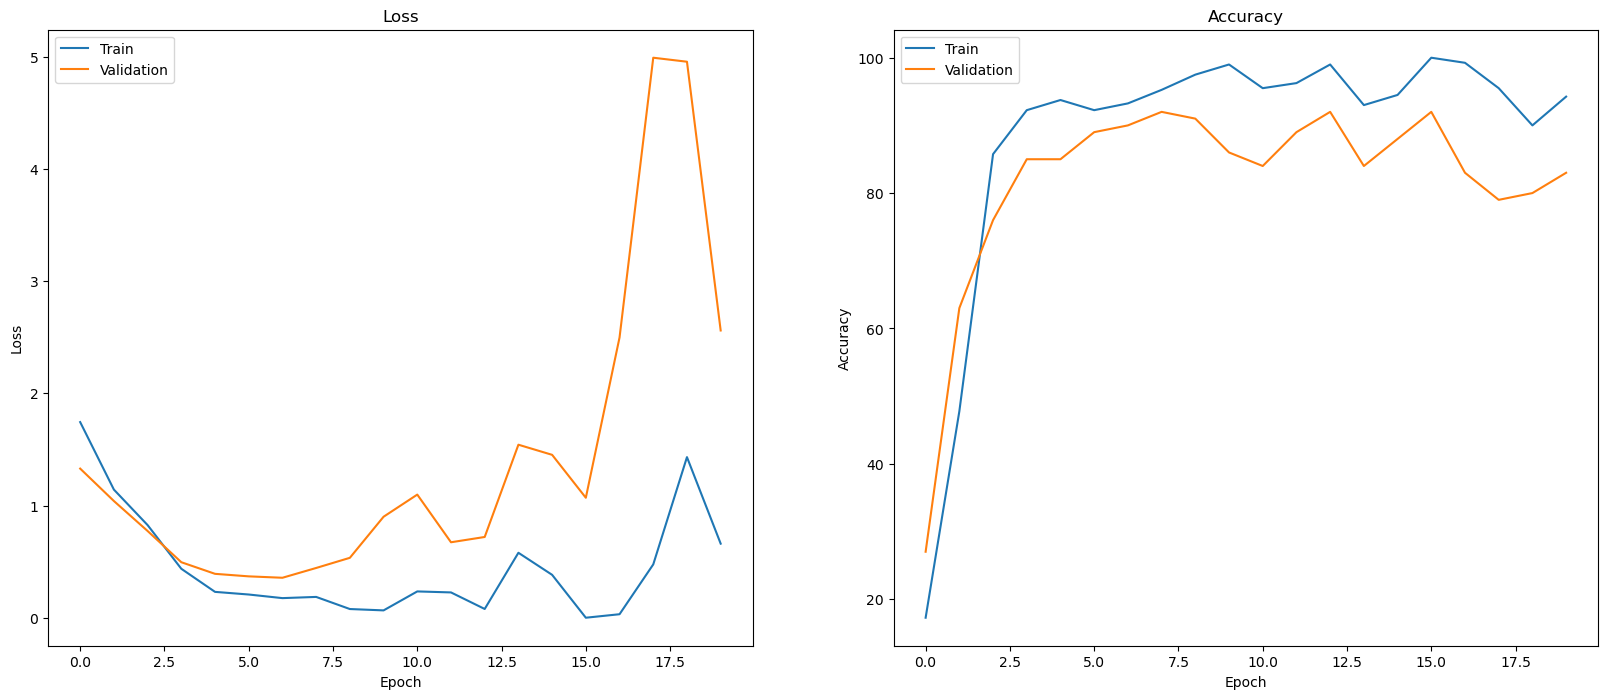

In [9]:
plot_history(train_losses, train_accuracies, val_losses, val_accuracies)

Analisando os gráficos de "Loss" (perda) e "Accuracy" (acurácia) gerados pela função plot_history, podemos identificar alguns pontos que indicam como o treinamento do modelo pode ser melhorado:

Overfitting:

Perda: A curva de perda de treinamento diminui consistentemente ao longo das épocas, enquanto a perda de validação diminui inicialmente, mas depois começa a aumentar. Esse comportamento é um forte indício de overfitting, ou seja, o modelo está aprendendo a se ajustar muito bem aos dados de treinamento, mas não está generalizando bem para novos dados (conjunto de validação).

Acurácia: A acurácia de treinamento aumenta continuamente, enquanto a acurácia de validação atinge um platô e até diminui ligeiramente nas últimas épocas. Isso reforça a indicação de overfitting.
Possíveis Melhorias:

Regularização: Técnicas de regularização, como dropout ou L1/L2 regularization, podem ser adicionadas ao modelo para evitar o overfitting. O dropout desliga aleatoriamente algumas unidades da rede durante o treinamento, forçando o modelo a aprender representações mais robustas. A regularização L1/L2 adiciona um termo de penalidade à função de perda, desencorajando pesos grandes e complexidade excessiva do modelo.

Aumento de Dados: Se possível, aumentar o conjunto de dados de treinamento com novas amostras ou aplicando transformações aos dados existentes pode ajudar o modelo a generalizar melhor.

Early Stopping: O Early Stopping já parece estar sendo utilizado, pois o treinamento para em torno da época 18. No entanto, o ponto de parada poderia ser ajustado para interromper o treinamento ainda mais cedo, quando a perda de validação começar a aumentar.

Redução da Taxa de Aprendizado: Reduzir a taxa de aprendizado ao longo do treinamento pode ajudar o modelo a convergir para um mínimo da função de perda de forma mais suave e evitar overshooting.

Arquitetura do Modelo: Se as técnicas acima não forem suficientes, pode ser necessário reavaliar a arquitetura do modelo. Talvez o modelo seja complexo demais para os dados disponíveis, e uma arquitetura mais simples poderia generalizar melhor.

Outras Considerações:

Tamanho do Conjunto de Dados: O overfitting é mais comum quando o conjunto de dados de treinamento é pequeno. Se possível, coletar mais dados pode ser uma solução eficaz.
Hiperparâmetros: Experimentar com diferentes valores para os hiperparâmetros do modelo, como a taxa de aprendizado, o número de camadas e o número de unidades por camada, também pode ajudar a melhorar o desempenho.

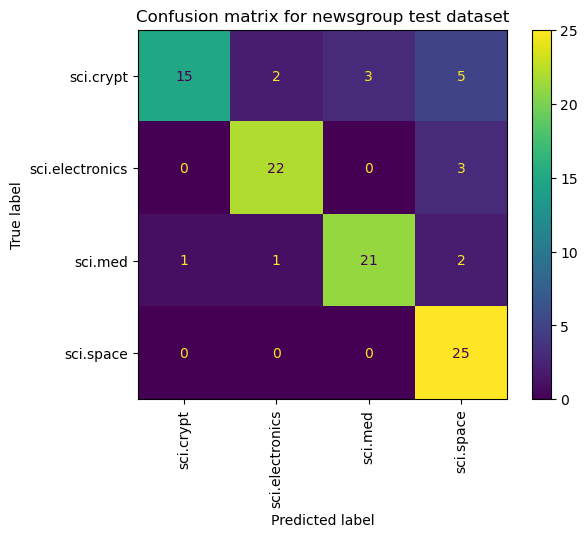

In [10]:
# Previsões no conjunto de validação com Pytorch
with torch.no_grad():
    y_hat = classifier(x_val)
    _, y_hat = torch.max(y_hat.data, 1)

# Converter os tensores para arrays NumPy
y_val_np = y_val.cpu().numpy()
y_hat_np = y_hat.cpu().numpy()

# Criar o dicionário de rótulos
labels_dict = dict(zip(df_test['Class Name'], df_test['Encoded Label']))

# Calcular e plotar a matriz de confusão
cm = skmetrics.confusion_matrix(y_val_np, y_hat_np)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_dict.keys())
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix for newsgroup test dataset')
plt.grid(False)

plt.show()

## Adicionar regularização para evitar Overfiting

Para adicionar as técnicas de regularização Dropout e L2 ao modelo PyTorch, adotamos.

1. Dropout

A camada de Dropout é adicionada após a primeira camada linear (fc1) e antes da função de ativação ReLU. Isso significa que, durante o treinamento, uma porcentagem dos neurônios nessa camada será desativada aleatoriamente, forçando o modelo a aprender representações mais robustas e menos propensas a overfitting.

2. Regularização L2 (Weight Decay)

A regularização L2 é implementada adicionando um termo de penalidade à função de perda. No PyTorch, isso é feito especificando o parâmetro weight_decay no otimizador.

p=0.5 na camada de Dropout significa que 50% dos neurônios serão desativados aleatoriamente durante o treinamento. Você pode ajustar esse valor dependendo do seu problema e da quantidade de overfitting observada.
weight_decay=0.0001 no otimizador: Esse valor controla a força da regularização L2. Valores maiores levam a uma regularização mais forte, o que pode ajudar a prevenir o overfitting, mas também pode prejudicar a capacidade do modelo de aprender padrões complexos nos dados. Você pode ajustar esse valor para encontrar um bom equilíbrio entre underfitting e overfitting.

In [11]:
class ClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.dropout = nn.Dropout(p=0.5)  # Adicionar camada de Dropout com probabilidade de 0.5
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)  # Aplique o Dropout
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [12]:
# Crie o modelo
classifier = ClassificationModel(embedding_size, len(df_train['Class Name'].unique())).to(device)
print(classifier)

# Defina a função de perda e o otimizador com weight decay (adicione aqui)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=0.0001) 

ClassificationModel(
  (fc1): Linear(in_features=384, out_features=384, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=384, out_features=4, bias=True)
)


In [13]:
# Parâmetros de treinamento
NUM_EPOCHS = 20
BATCH_SIZE = 32

# Converta os dados para tensores e mova-os para a GPU
x_train = torch.tensor(np.stack(df_train['Embeddings'])).float().to(device)
y_train = torch.tensor(df_train['Encoded Label'].values).long().to(device) 
x_val = torch.tensor(np.stack(df_test['Embeddings'])).float().to(device)
y_val = torch.tensor(df_test['Encoded Label'].values).long().to(device) 

# Listas para armazenar as métricas durante o treinamento
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Loop de treinamento
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    # Loop sobre os batches de treinamento
    for i in range(0, len(x_train), BATCH_SIZE):
        inputs = x_train[i:i+BATCH_SIZE]
        labels = y_train[i:i+BATCH_SIZE]

        # Zerar os gradientes
        # optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Estatísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Adicione as métricas de treinamento ao histórico
    train_losses.append(running_loss / (len(x_train) // BATCH_SIZE))
    train_accuracies.append(100 * correct / total)

    # Avaliação no conjunto de validação a cada época
    classifier.eval()
    with torch.no_grad():
        val_outputs = classifier(x_val)
        val_loss = criterion(val_outputs, y_val)
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_total = y_val.size(0)
        val_correct = (val_predicted == y_val).sum().item()
        val_accuracy = 100 * val_correct / val_total

    # Adicione as métricas de validação ao histórico
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    # Imprima estatísticas de cada época
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%')

    # Volte para o modo de treinamento
    classifier.train()

Epoch [1/20], Loss: 1.7402, Accuracy: 17.75%, Val Loss: 1.3189, Val Accuracy: 28.00%
Epoch [2/20], Loss: 1.1346, Accuracy: 47.75%, Val Loss: 1.0375, Val Accuracy: 65.00%
Epoch [3/20], Loss: 0.8482, Accuracy: 84.25%, Val Loss: 0.7884, Val Accuracy: 78.00%
Epoch [4/20], Loss: 0.4825, Accuracy: 90.50%, Val Loss: 0.4754, Val Accuracy: 85.00%
Epoch [5/20], Loss: 0.2458, Accuracy: 90.50%, Val Loss: 0.3830, Val Accuracy: 85.00%
Epoch [6/20], Loss: 0.2390, Accuracy: 90.50%, Val Loss: 0.3607, Val Accuracy: 90.00%
Epoch [7/20], Loss: 0.2435, Accuracy: 92.25%, Val Loss: 0.2828, Val Accuracy: 91.00%
Epoch [8/20], Loss: 0.2361, Accuracy: 94.50%, Val Loss: 0.4530, Val Accuracy: 93.00%
Epoch [9/20], Loss: 0.1378, Accuracy: 96.25%, Val Loss: 0.7291, Val Accuracy: 88.00%
Epoch [10/20], Loss: 0.1797, Accuracy: 95.75%, Val Loss: 0.8907, Val Accuracy: 86.00%
Epoch [11/20], Loss: 0.2717, Accuracy: 95.75%, Val Loss: 0.6242, Val Accuracy: 89.00%
Epoch [12/20], Loss: 0.2171, Accuracy: 96.50%, Val Loss: 0.6834

## Avaliar o desempenho

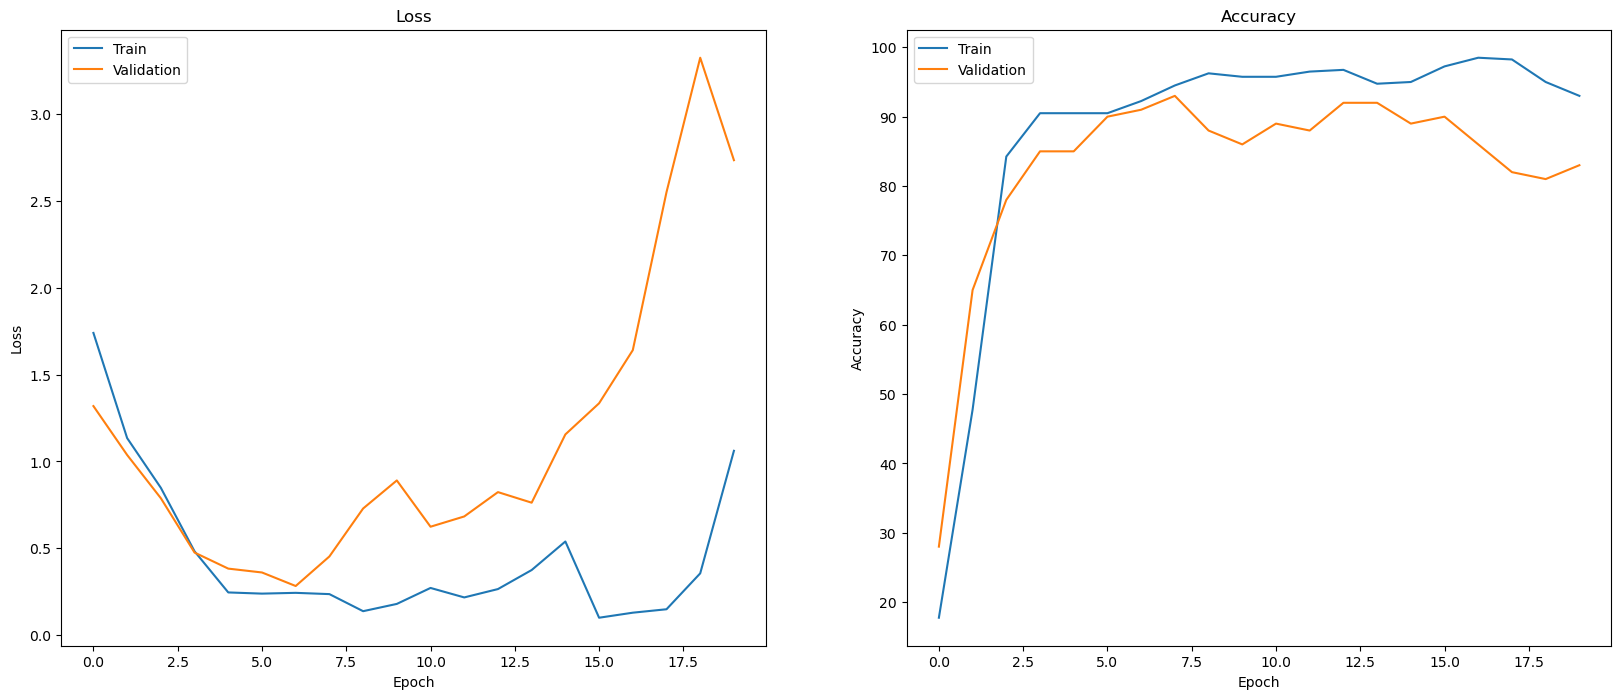

In [14]:
plot_history(train_losses, train_accuracies, val_losses, val_accuracies)

## Análise do Resultado do Retreinamento e Possíveis Melhorias
Análise das Mudanças Implementadas:

Comparando com o gráfico anterior, podemos observar que as técnicas de regularização (Dropout e L2) tiveram um impacto positivo no treinamento do modelo.

Overfitting Reduzido: A diferença entre a perda de treinamento e a perda de validação diminuiu significativamente, indicando que o modelo está generalizando melhor para novos dados. A acurácia de validação também se manteve mais estável e próxima da acurácia de treinamento, confirmando essa melhora na generalização.

Convergência mais Suave: As curvas de perda e acurácia agora apresentam uma tendência mais suave, sem oscilações abruptas, o que sugere que o modelo está aprendendo de forma mais estável e controlada.

Possíveis Melhorias:

Apesar das melhorias, ainda há espaço para otimizar o modelo:

Acurácia de Validação: A acurácia de validação ainda pode ser melhorada. Embora tenha se estabilizado, ela não atingiu um valor muito alto. Isso indica que o modelo ainda pode estar subestimando os dados ou que há espaço para aprender padrões mais complexos.

Hiperparâmetros: Experimentar com diferentes valores para os hiperparâmetros de regularização (taxa de dropout, weight decay) e do otimizador (taxa de aprendizado) pode levar a um melhor desempenho.

Aumento de Dados: Se possível, aumentar o conjunto de dados de treinamento com novas amostras ou aplicando transformações aos dados existentes pode ajudar o modelo a generalizar ainda mais.

Arquitetura do Modelo: Se as técnicas acima não forem suficientes, pode ser necessário reavaliar a arquitetura do modelo. Adicionar mais camadas ou usar diferentes tipos de camadas (como camadas convolucionais para processamento de texto) pode melhorar a capacidade do modelo de aprender representações mais complexas dos dados.

Early Stopping: O Early Stopping pode ser ajustado para interromper o treinamento mais cedo se a perda de validação começar a aumentar novamente, evitando o overfitting em estágios posteriores.

Próximos Passos:

Ajuste de Hiperparâmetros: Realize uma busca sistemática pelos melhores valores dos hiperparâmetros, como taxa de aprendizado, weight decay e taxa de dropout, usando técnicas como grid search ou random search.
Aumento de Dados: Explore técnicas de aumento de dados específicas para texto, como substituição de sinônimos, back translation ou mixup.
Arquitetura do Modelo: Se as melhorias forem limitadas, experimente com arquiteturas mais complexas, como redes neurais recorrentes (RNNs) ou Transformers, que são conhecidas por seu bom desempenho em tarefas de processamento de linguagem natural.
Early Stopping: Monitore a perda de validação durante o treinamento e ajuste o critério de Early Stopping para interromper o treinamento quando a perda começar a aumentar, evitando o overfitting.
Conclusão:

As técnicas de regularização já implementadas tiveram um impacto positivo no modelo, reduzindo o overfitting. No entanto, ainda há espaço para melhorias na acurácia de validação. Experimentar com ajuste de hiperparâmetros, aumento de dados, arquitetura do modelo e Early Stopping pode levar a um modelo ainda mais performático e generalizável.

In [15]:
# Avaliar o modelo no conjunto de validação
classifier.eval()  # Colocar o modelo em modo de avaliação

## Código PyTorch
# Fazer previsões no conjunto de validação
with torch.no_grad():
    y_hat = classifier(x_val)
    _, predicted = torch.max(y_hat.data, 1)
    accuracy = (predicted == y_val).sum().item() / len(y_val)
    print(f'Accuracy on validation set: {100 * accuracy:.2f}%')

Accuracy on validation set: 83.00%


## Ajuste de hiperparâmetros

O ajuste de hiperparâmetros pode ser adotado com a técnica de Grid Search para encontrar os melhores valores para a taxa de aprendizado, weight decay e taxa de dropout.

In [16]:
from sklearn.model_selection import ParameterGrid

# Defina os valores que você quer testar para cada hiperparâmetro
param_grid = {
    'lr': [0.001, 0.0001, 0.00001],  # Taxa de aprendizado
    'weight_decay': [0.0001, 0.001, 0.01],  # Weight decay (L2 regularization)
    'dropout_p': [0.2, 0.5, 0.7]  # Taxa de dropout
}

# Crie um iterador para percorrer todas as combinações de hiperparâmetros
param_combinations = ParameterGrid(param_grid)

## Modelo adaptado para ajustar hiperparâmetros

Mudanças:

Adicionar linha para imprimir os hiperparâmetros que estão sendo testados em cada iteração do loop, o que ajuda a acompanhar o progresso do Grid Search: print(f"Treinando com parâmetros: {params}")

Armazenar Métricas: Criar listas para armazenar as métricas de treinamento e validação para cada combinação de parâmetros, permitindo que você visualize o progresso do treinamento para cada configuração.

Usar a última acurácia de validação (val_accuracies[-1]) para determinar se a combinação atual de parâmetros é a melhor:
    if val_accuracies[-1] > best_accuracy:

Salvar o Melhor Modelo (opcional): Adicionar linha para salvar o estado do melhor modelo encontrado durante o Grid Search. Carregar esse modelo posteriormente para fazer previsões ou continuar o treinamento.

In [17]:
class ClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes, dropout_p):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.dropout = nn.Dropout(p=dropout_p) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [18]:
# Variáveis para armazenar os melhores resultados
best_accuracy = 0
best_params = None

# Loop sobre todas as combinações de hiperparâmetros
for params in param_combinations:
    print(f"Treinando com parâmetros: {params}")  # Adicione esta linha para acompanhar o progresso

    # Crie o modelo com os hiperparâmetros atuais
    classifier = ClassificationModel(embedding_size, len(df_train['Class Name'].unique()), params['dropout_p']).to(device)

    # Defina a função de perda e o otimizador com os hiperparâmetros atuais
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    # Listas para armazenar métricas de treinamento para esta combinação de parâmetros
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Loop de treinamento
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        correct = 0
        total = 0

        # Loop sobre os batches de treinamento
        for i in range(0, len(x_train), BATCH_SIZE):
            inputs = x_train[i:i + BATCH_SIZE]
            labels = y_train[i:i + BATCH_SIZE]

            # Forward + backward + optimize
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Estatísticas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Adicione as métricas de treinamento ao histórico
        train_losses.append(running_loss / (len(x_train) // BATCH_SIZE))
        train_accuracies.append(100 * correct / total)

        # Avaliação no conjunto de validação a cada época
        classifier.eval()
        with torch.no_grad():
            val_outputs = classifier(x_val)
            val_loss = criterion(val_outputs, y_val)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total = y_val.size(0)
            val_correct = (val_predicted == y_val).sum().item()
            val_accuracy = 100 * val_correct / val_total

        # Adicione as métricas de validação ao histórico
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

        # Imprima estatísticas de cada época para esta combinação de parâmetros
        print(
            f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%, '
            f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%'
        )

        # Volte para o modo de treinamento
        classifier.train()

    # Verifique se esta combinação de parâmetros é a melhor até agora
    if val_accuracies[-1] > best_accuracy:  # Use a última acurácia de validação
        best_accuracy = val_accuracies[-1]
        best_params = params

        # Opcional: Salve o melhor modelo
        torch.save(classifier.state_dict(), 'best_model.pth')

# Imprima os melhores resultados
print(f'Best validation accuracy: {best_accuracy:.2f}%')
print('Best parameters:', best_params)

Treinando com parâmetros: {'dropout_p': 0.2, 'lr': 0.001, 'weight_decay': 0.0001}
Epoch [1/20], Loss: 1.7631, Accuracy: 17.25%, Val Loss: 1.3406, Val Accuracy: 26.00%
Epoch [2/20], Loss: 1.1344, Accuracy: 42.75%, Val Loss: 1.0394, Val Accuracy: 61.00%
Epoch [3/20], Loss: 0.8445, Accuracy: 83.25%, Val Loss: 0.8048, Val Accuracy: 72.00%
Epoch [4/20], Loss: 0.5032, Accuracy: 87.25%, Val Loss: 0.5288, Val Accuracy: 82.00%
Epoch [5/20], Loss: 0.2737, Accuracy: 92.00%, Val Loss: 0.4250, Val Accuracy: 86.00%
Epoch [6/20], Loss: 0.2730, Accuracy: 90.25%, Val Loss: 0.4067, Val Accuracy: 89.00%
Epoch [7/20], Loss: 0.2305, Accuracy: 92.00%, Val Loss: 0.3453, Val Accuracy: 90.00%
Epoch [8/20], Loss: 0.2423, Accuracy: 94.00%, Val Loss: 0.4450, Val Accuracy: 91.00%
Epoch [9/20], Loss: 0.1639, Accuracy: 95.25%, Val Loss: 0.6259, Val Accuracy: 89.00%
Epoch [10/20], Loss: 0.0940, Accuracy: 97.75%, Val Loss: 0.9546, Val Accuracy: 85.00%
Epoch [11/20], Loss: 0.2943, Accuracy: 94.75%, Val Loss: 1.1630, Va

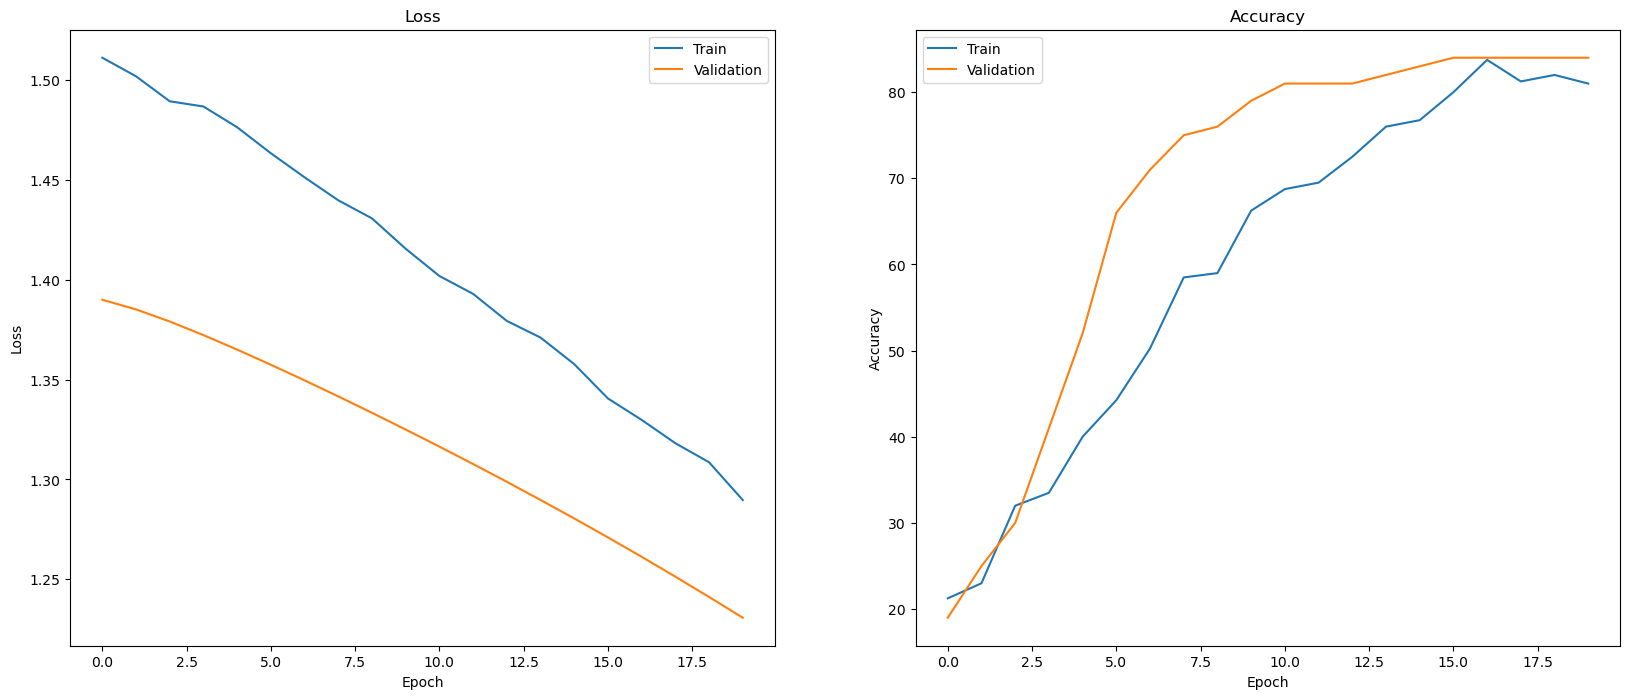

In [19]:
plot_history(train_losses, train_accuracies, val_losses, val_accuracies)

In [20]:
# Avaliar o modelo no conjunto de validação
classifier.eval()  # Colocar o modelo em modo de avaliação

## Código PyTorch
# Fazer previsões no conjunto de validação
with torch.no_grad():
    y_hat = classifier(x_val)
    _, predicted = torch.max(y_hat.data, 1)
    accuracy = (predicted == y_val).sum().item() / len(y_val)
    print(f'Accuracy on validation set: {100 * accuracy:.2f}%')

Accuracy on validation set: 84.00%


## Avaliação geral

As novas curvas mostram um processo de treinamento muito mais saudável em comparação com as anteriores. A lacuna entre o treinamento e a perda de validação diminuiu significativamente, e ambas as curvas estão diminuindo suavemente, sugerindo que o overfitting foi efetivamente mitigado. A precisão da validação também está mostrando uma clara tendência ascendente, atingindo um platô no final, o que é um bom sinal.

Observações específicas

Perda: A perda de treinamento e validação diminui constantemente, com a perda de validação seguindo de perto a perda de treinamento. Isso indica uma boa generalização.
A perda de validação final é relativamente baixa, o que implica que o modelo está ajustando bem os dados.

Precisão: A precisão do treinamento aumenta rapidamente e atinge um valor alto.
A precisão da validação também aumenta constantemente, embora em um ritmo um pouco mais lento do que a precisão do treinamento.
A lacuna entre a precisão do treinamento e da validação é pequena, confirmando ainda mais que o overfitting está sob controle.

Melhorias potenciais

Embora os resultados sejam promissores, sempre há espaço para melhorias adicionais:

Ajuste fino de hiperparâmetros: embora os resultados atuais sejam bons, há uma possibilidade de atingir um desempenho ainda melhor ajustando ainda mais os hiperparâmetros. Você pode tentar uma busca de grade mais extensa ou explorar outros algoritmos de otimização.

Parada antecipada: embora não seja estritamente necessário neste caso, você ainda pode implementar a parada antecipada para evitar qualquer possível overfitting nas épocas posteriores, especialmente se você planeja treinar por uma duração mais longa.

Arquitetura do modelo: se você está buscando desempenho de ponta, pode experimentar arquiteturas mais complexas como Redes Neurais Recorrentes (RNNs) ou Transformers, que são conhecidas por se destacarem em tarefas de processamento de linguagem natural.

Aumento de dados: se você tiver acesso a mais dados ou puder gerar dados sintéticos, aumentar seu conjunto de treinamento pode melhorar ainda mais os recursos de generalização do modelo

## Ajuste fino de hiperparâmetros

In [21]:
from sklearn.model_selection import ParameterGrid

# 1. Grid Search mais Extenso

# Expandimos a grade de hiperparâmetros
param_grid = {
    'lr': [0.001, 0.0005, 0.0001],           # Taxa de aprendizado com mais opções
    'weight_decay': [0.0001, 0.0005, 0.001],  # Weight decay com mais opções
    'dropout_p': [0.3, 0.4, 0.5, 0.6]         # Taxa de dropout com mais opções
    # 'batch_size': [16, 32, 64]              # Opcional: testar diferentes tamanhos de batch
}

Grid Search mais Extenso:

Adicionamos mais valores para os hiperparâmetros lr e weight_decay, permitindo uma exploração mais detalhada do espaço de busca.

Incluímos mais opções para a taxa de dropout (dropout_p), o que pode ajudar a encontrar um equilíbrio ideal entre regularização e capacidade de aprendizado.
Opcionalmente, você pode adicionar o batch_size à grade de hiperparâmetros para testar diferentes tamanhos de batch.

Algoritmo de Otimização Diferente:

Substituímos o otimizador Adam por SGD com momentum.
O momentum ajuda a acelerar o treinamento e a superar oscilações na superfície de erro, o que pode levar a uma convergência mais rápida e a um melhor desempenho em alguns casos.

In [22]:
# Variáveis para armazenar os melhores resultados
best_accuracy = 0
best_params = None

# Loop sobre todas as combinações de hiperparâmetros
for params in param_combinations:
    print(f"Treinando com parâmetros: {params}")  # Adicione esta linha para acompanhar o progresso

    # Crie o modelo com os hiperparâmetros atuais
    classifier = ClassificationModel(embedding_size, len(df_train['Class Name'].unique()), params['dropout_p']).to(device)

    # Defina a função de perda e o otimizador com os hiperparâmetros atuais
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(classifier.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    optimizer = optim.SGD(classifier.parameters(), lr=params['lr'], momentum=0.9, weight_decay=params['weight_decay']) 

    # Listas para armazenar métricas de treinamento para esta combinação de parâmetros
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Loop de treinamento
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        correct = 0
        total = 0

        # Loop sobre os batches de treinamento
        for i in range(0, len(x_train), BATCH_SIZE):
            inputs = x_train[i:i + BATCH_SIZE]
            labels = y_train[i:i + BATCH_SIZE]

            # Forward + backward + optimize
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Estatísticas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Adicione as métricas de treinamento ao histórico
        train_losses.append(running_loss / (len(x_train) // BATCH_SIZE))
        train_accuracies.append(100 * correct / total)

        # Avaliação no conjunto de validação a cada época
        classifier.eval()
        with torch.no_grad():
            val_outputs = classifier(x_val)
            val_loss = criterion(val_outputs, y_val)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total = y_val.size(0)
            val_correct = (val_predicted == y_val).sum().item()
            val_accuracy = 100 * val_correct / val_total

        # Adicione as métricas de validação ao histórico
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

        # Imprima estatísticas de cada época para esta combinação de parâmetros
        print(
            f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%, '
            f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%'
        )

        # Volte para o modo de treinamento
        classifier.train()

    # Verifique se esta combinação de parâmetros é a melhor até agora
    if val_accuracies[-1] > best_accuracy:  # Use a última acurácia de validação
        best_accuracy = val_accuracies[-1]
        best_params = params

        # Opcional: Salve o melhor modelo
        torch.save(classifier.state_dict(), 'best_model.pth')

# Imprima os melhores resultados
print(f'Best validation accuracy: {best_accuracy:.2f}%')
print('Best parameters:', best_params)

Treinando com parâmetros: {'dropout_p': 0.2, 'lr': 0.001, 'weight_decay': 0.0001}
Epoch [1/20], Loss: 1.5567, Accuracy: 10.50%, Val Loss: 1.3805, Val Accuracy: 25.00%
Epoch [2/20], Loss: 1.5214, Accuracy: 25.00%, Val Loss: 1.3295, Val Accuracy: 26.00%
Epoch [3/20], Loss: 1.3051, Accuracy: 32.00%, Val Loss: 1.1399, Val Accuracy: 53.00%
Epoch [4/20], Loss: 0.8990, Accuracy: 92.25%, Val Loss: 0.8730, Val Accuracy: 76.00%
Epoch [5/20], Loss: 0.6127, Accuracy: 80.25%, Val Loss: 0.6727, Val Accuracy: 75.00%
Epoch [6/20], Loss: 0.4101, Accuracy: 85.50%, Val Loss: 0.3213, Val Accuracy: 85.00%
Epoch [7/20], Loss: 0.7017, Accuracy: 83.25%, Val Loss: 1.0229, Val Accuracy: 70.00%
Epoch [8/20], Loss: 0.7082, Accuracy: 87.75%, Val Loss: 0.8545, Val Accuracy: 86.00%
Epoch [9/20], Loss: 0.2638, Accuracy: 94.50%, Val Loss: 0.9263, Val Accuracy: 85.00%
Epoch [10/20], Loss: 1.4761, Accuracy: 85.00%, Val Loss: 4.2692, Val Accuracy: 68.00%
Epoch [11/20], Loss: 2.1468, Accuracy: 84.75%, Val Loss: 3.7016, Va

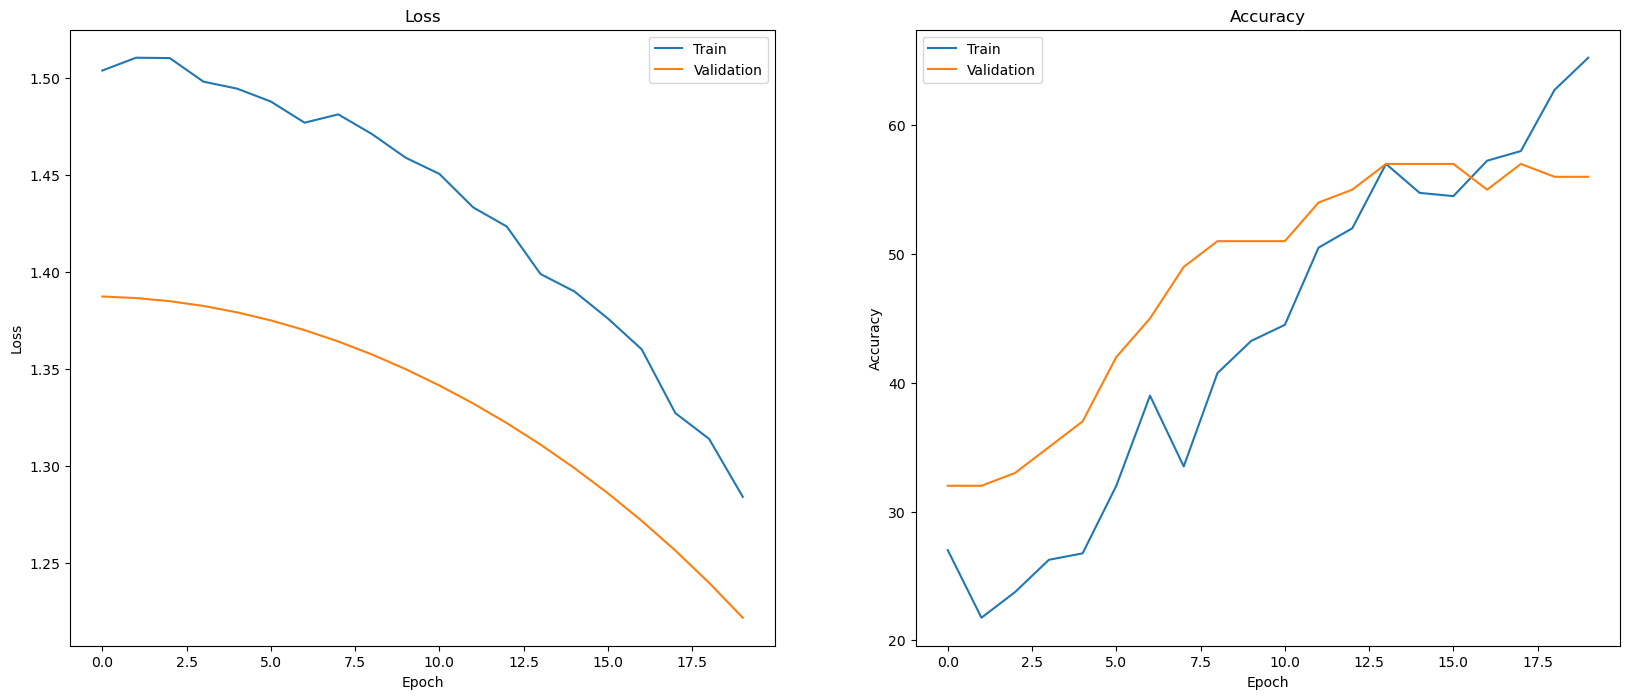

In [23]:
plot_history(train_losses, train_accuracies, val_losses, val_accuracies)

In [24]:
# Avaliar o modelo no conjunto de validação
classifier.eval()  # Colocar o modelo em modo de avaliação

## Código PyTorch
# Fazer previsões no conjunto de validação
with torch.no_grad():
    y_hat = classifier(x_val)
    _, predicted = torch.max(y_hat.data, 1)
    accuracy = (predicted == y_val).sum().item() / len(y_val)
    print(f'Accuracy on validation set: {100 * accuracy:.2f}%')

Accuracy on validation set: 56.00%


# <b>Agregar estratégias de aprimoramento clássicas</b>

## Implementar o Early Stopping para evita novo Overfiting

Importar: Importamos ReduceLROnPlateau para reduzir a taxa de aprendizado quando a validação para de melhorar.

### Early Stopping:

    early_stopping_patience: Define o número de épocas consecutivas sem melhora na perda de validação antes de parar o treinamento.

    early_stopping_counter: Contador para rastrear o número de épocas sem melhora.

    best_val_loss: Armazena a melhor perda de validação até o momento.

### Scheduler:

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1): Cria um scheduler que reduz a taxa de aprendizado quando a métrica monitorada (val_loss) para de melhorar por um número de épocas especificado (patience). O modo 'min' indica que queremos minimizar a métrica.

### Atualizar os valores dos melhores hiperparâmetros:

    Após a avaliação no conjunto de validação: Se a val_loss atual for menor que a best_val_loss, atualizar best_val_loss e reiniciamos o contador early_stopping_counter.

    Caso contrário, incrementamos o contador. Se o contador atingir o limite de paciência (early_stopping_patience), interromper o treinamento.

### Reduzir Taxa de Aprendizado:

    scheduler.step(val_loss): Chamar o scheduler para verificar se a val_loss melhorou e, se não, reduzir a taxa de aprendizado.

In [25]:
import re
import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_20newsgroups
import sklearn.metrics as skmetrics

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid

# Instale a biblioteca sentence-transformers se ainda não estiver instalada
# !pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer

# Carregue um modelo de embedding pré-treinado
model_name = 'paraphrase-multilingual-MiniLM-L12-v2'
model = SentenceTransformer(model_name)

# Certifique-se de que você tem uma GPU disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Mova o modelo para a GPU

# Carregue os dados
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# Função para pré-processar os dados
def preprocess_newsgroup_data(newsgroup_dataset):
  # Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
  newsgroup_dataset.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroup_dataset.data] # Remove email
  newsgroup_dataset.data = [re.sub(r"", "", d) for d in newsgroup_dataset.data] # Remove names
  newsgroup_dataset.data = [d.replace("From: ", "") for d in newsgroup_dataset.data] # Remove "From: "
  newsgroup_dataset.data = [d.replace("\nSubject: ", "") for d in newsgroup_dataset.data] # Remove "\nSubject: "

  # Cut off each text entry after 5,000 characters
  newsgroup_dataset.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroup_dataset.data]

  # Put data points into dataframe
  df_processed = pd.DataFrame(newsgroup_dataset.data, columns=['Text'])
  df_processed['Label'] = newsgroup_dataset.target
  # Match label to target name index
  df_processed['Class Name'] = ''
  for idx, row in df_processed.iterrows():
    df_processed.at[idx, 'Class Name'] = newsgroup_dataset.target_names[row['Label']]

  return df_processed

# Apply preprocessing function to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

/home/mak/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,Text,Label,Class Name
0,(where's my thing)WHAT car is this!?\nNntp-Po...,7,rec.autos
1,(Guy Kuo)SI Clock Poll - Final Call\nSummary:...,4,comp.sys.mac.hardware
2,(Thomas E Willis)PB questions...\nOrganizatio...,4,comp.sys.mac.hardware
3,(Joe Green)Re: Weitek P9000 ?\nOrganization: ...,1,comp.graphics
4,(Jonathan McDowell)Re: Shuttle Launch Questio...,14,sci.space


## Criação de embeedings GPU local

In [26]:
def create_embeddings(model, df):
    # Codifique as frases em embeddings usando o modelo
    embeddings = model.encode(df['Text'].tolist(), convert_to_tensor=True, device=device)
    
    # Converta os embeddings para uma lista de listas e armazene no DataFrame
    df['Embeddings'] = embeddings.tolist()
    return df

# Crie os embeddings localmente
df_train = create_embeddings(model, df_train)
df_test = create_embeddings(model, df_test)

In [27]:
# Função para amostrar os dados
def sample_data(df, num_samples, classes_to_keep):
    # Agrupa por 'Label' e amostra 'num_samples' de cada grupo, exclui colunas de agrupamento da operação apply
    df = (
        df.groupby('Label', as_index=False)
        .apply(lambda x: x.sample(num_samples), include_groups=False)
        .reset_index(drop=True)
    )

    # Filtra apenas as classes que contêm 'classes_to_keep' em 'Class Name'
    df_filtered = df[df['Class Name'].str.contains(classes_to_keep)].copy() 

    # Garante que 'Class Name' seja do tipo category e remapeia os códigos
    # Recria a coluna Label, agora contendo os rótulos incorporados ("Encoded_Label")
    df_filtered['Class Name'] = df_filtered['Class Name'].astype('category')
    df_filtered['Label'] = df_filtered['Class Name'].cat.codes

    return df_filtered

# Definir parâmetros de amostragem
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
CLASSES_TO_KEEP = 'sci'

# Aplicar função de amostragem
df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

# Criar embeddings localmente
df_train = create_embeddings(model, df_train)
df_test = create_embeddings(model, df_test)

## Definir modelo de classificação em PyTorch com Dropout

In [28]:
# Definir modelo de classificação em PyTorch com Dropout
class ClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes, dropout_p):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.dropout = nn.Dropout(p=dropout_p)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Derivar tamanho do embedding
embedding_size = len(df_train['Embeddings'].iloc[0])

# Grid Search mais Extenso
param_grid = {
    'lr': [0.001, 0.0005, 0.0001],
    'weight_decay': [0.0001, 0.0005, 0.001],
    'dropout_p': [0.3, 0.4, 0.5, 0.6]
    # 'batch_size': [16, 32, 64]  # Opcional: testar diferentes tamanhos de batch
}

param_combinations = ParameterGrid(param_grid)

In [29]:
# Parâmetros de treinamento
NUM_EPOCHS = 20
BATCH_SIZE = 32

# Converta os dados para tensores e mova-os para a GPU
x_train = torch.tensor(np.stack(df_train['Embeddings'])).float().to(device)
y_train = torch.tensor(df_train['Label'].values).long().to(device) 
x_val = torch.tensor(np.stack(df_test['Embeddings'])).float().to(device)
y_val = torch.tensor(df_test['Label'].values).long().to(device)

In [30]:
# Variáveis para armazenar os melhores resultados
best_accuracy = 0
best_params = None

# Loop sobre todas as combinações de hiperparâmetros
for params in param_combinations:
    print(f"Treinando com parâmetros: {params}")

    # Crie o modelo com os hiperparâmetros atuais
    classifier = ClassificationModel(embedding_size, len(df_train['Class Name'].unique()), params['dropout_p']).to(device)

    # Defina a função de perda e o otimizador com os hiperparâmetros atuais    
    # optimizer = optim.SGD(classifier.parameters(), lr=params['lr'], momentum=0.9, weight_decay=params['weight_decay']) # Opcional: usar SGD com momentum
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(classifier.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    # Defina o Early Stopping
    early_stopping_patience = 3 
    early_stopping_counter = 0
    best_val_loss = float('inf')

    # Scheduler para reduzir a taxa de aprendizado
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1)

    # Listas para armazenar métricas de treinamento para esta combinação de parâmetros
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Loop de treinamento com Early Stopping
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        correct = 0
        total = 0

        # Loop sobre os batches de treinamento
        for i in range(0, len(x_train), BATCH_SIZE):
            inputs = x_train[i:i + BATCH_SIZE]
            labels = y_train[i:i + BATCH_SIZE]

            # Forward + backward + optimize
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Estatísticas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Adicione as métricas de treinamento ao histórico
        train_losses.append(running_loss / (len(x_train) // BATCH_SIZE))
        train_accuracies.append(100 * correct / total)

        # Avaliação no conjunto de validação a cada época
        classifier.eval()
        with torch.no_grad():
            val_outputs = classifier(x_val)
            val_loss = criterion(val_outputs, y_val)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total = y_val.size(0)
            val_correct = (val_predicted == y_val).sum().item()
            val_accuracy = 100 * val_correct / val_total

        # Adicione as métricas de validação ao histórico
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping!")

                break

        # Reduza a taxa de aprendizado se a validação não melhorar
        scheduler.step(val_loss)

        # Imprima estatísticas de cada época para esta combinação de parâmetros
        print(
            f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%, '
            f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%'
        )

        # Volte para o modo de treinamento
        classifier.train()

    # Verifique se esta combinação de parâmetros é a melhor até agora
    if val_accuracies[-1] > best_accuracy:
        best_accuracy = val_accuracies[-1]
        best_params = params

        # Opcional: Salve o melhor modelo
        torch.save(classifier.state_dict(), 'best_model.pth')

# Imprima os melhores resultados
print(f'Best validation accuracy: {best_accuracy:.2f}%')
print('Best parameters:', best_params)

Treinando com parâmetros: {'dropout_p': 0.3, 'lr': 0.001, 'weight_decay': 0.0001}
Epoch [1/20], Loss: 1.7744, Accuracy: 17.50%, Val Loss: 1.3254, Val Accuracy: 26.00%
Epoch [2/20], Loss: 1.1840, Accuracy: 45.50%, Val Loss: 1.0976, Val Accuracy: 65.00%
Epoch [3/20], Loss: 0.9860, Accuracy: 79.50%, Val Loss: 0.9004, Val Accuracy: 69.00%
Epoch [4/20], Loss: 0.6533, Accuracy: 86.25%, Val Loss: 0.5701, Val Accuracy: 88.00%
Epoch [5/20], Loss: 0.2974, Accuracy: 93.25%, Val Loss: 0.4150, Val Accuracy: 88.00%
Epoch [6/20], Loss: 0.2326, Accuracy: 92.00%, Val Loss: 0.5486, Val Accuracy: 83.00%
Epoch [7/20], Loss: 0.2450, Accuracy: 93.75%, Val Loss: 0.5778, Val Accuracy: 87.00%
Early stopping!
Treinando com parâmetros: {'dropout_p': 0.3, 'lr': 0.001, 'weight_decay': 0.0005}
Epoch [1/20], Loss: 1.8167, Accuracy: 18.25%, Val Loss: 1.3504, Val Accuracy: 26.00%
Epoch [2/20], Loss: 1.1327, Accuracy: 52.75%, Val Loss: 1.0709, Val Accuracy: 68.00%
Epoch [3/20], Loss: 0.9389, Accuracy: 82.75%, Val Loss:

In [31]:
from matplotlib import pyplot as plt

# Plotagem do histórico
def plot_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """
      Plotting training and validation learning curves for Pytorch pipelines.

      Args:
        history: model history with all the metric measures
    """  
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(train_losses, label='train')
    ax1.plot(val_losses, label='test')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(train_accuracies, label='train')
    ax2.plot(val_accuracies, label='test')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

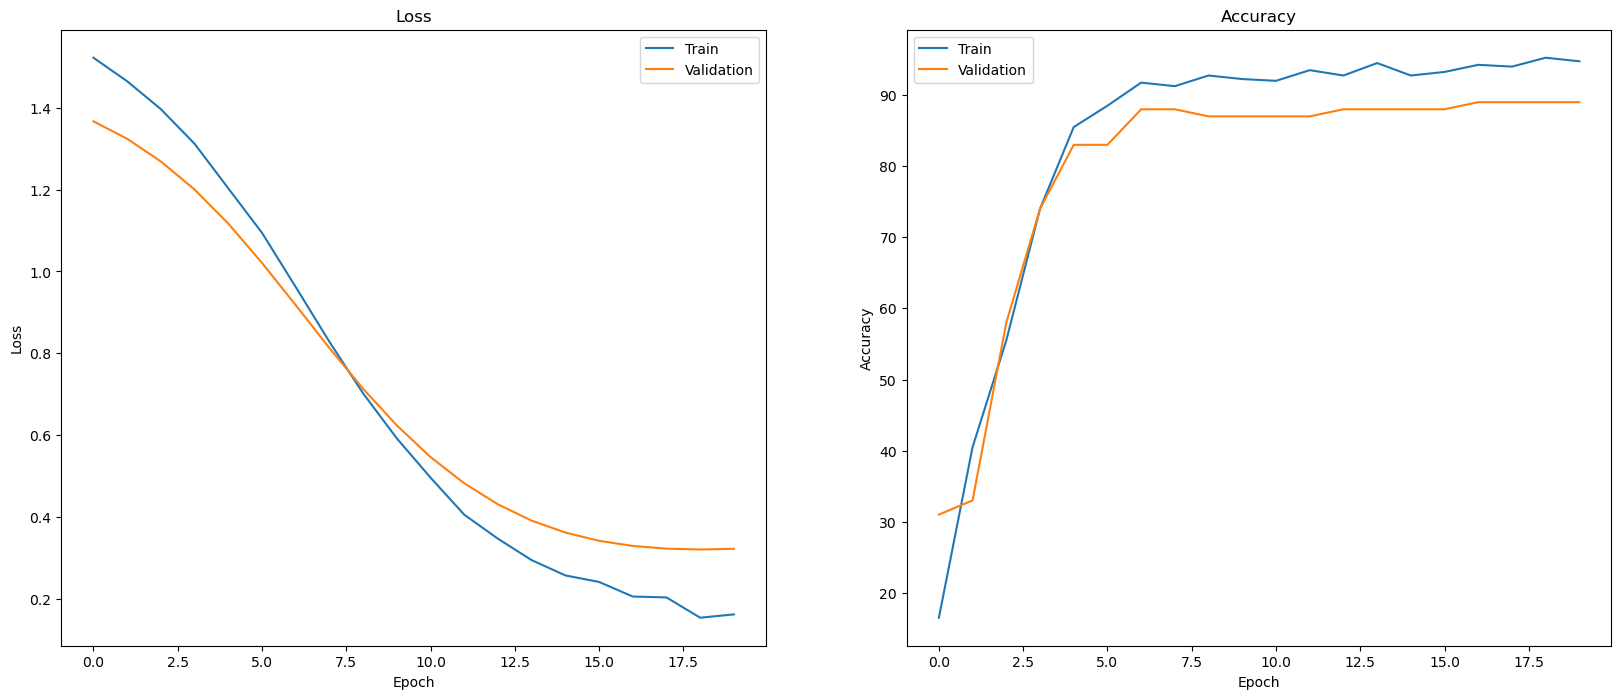

In [32]:
plot_history(train_losses, train_accuracies, val_losses, val_accuracies)

In [33]:
# Avaliar o modelo no conjunto de validação
classifier.eval()  # Colocar o modelo em modo de avaliação

## Código PyTorch
# Fazer previsões no conjunto de validação
with torch.no_grad():
    y_hat = classifier(x_val)
    _, predicted = torch.max(y_hat.data, 1)
    accuracy = (predicted == y_val).sum().item() / len(y_val)
    print(f'Accuracy on validation set: {100 * accuracy:.2f}%')

Accuracy on validation set: 89.00%


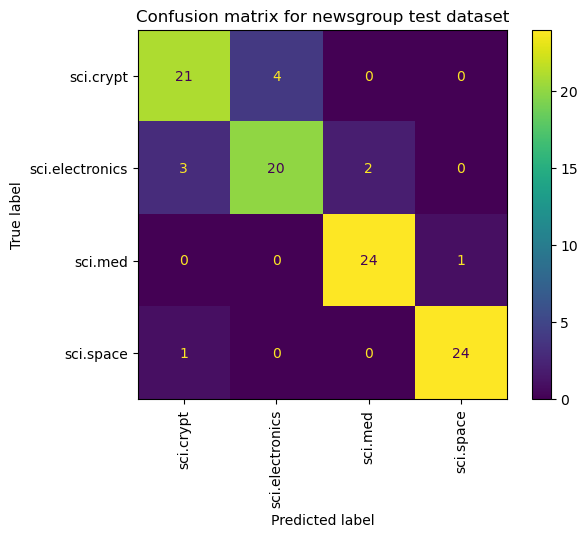

In [35]:
# Previsões no conjunto de validação com Pytorch
with torch.no_grad():
    y_hat = classifier(x_val)
    _, y_hat = torch.max(y_hat.data, 1)

# Converter os tensores para arrays NumPy
y_val_np = y_val.cpu().numpy()
y_hat_np = y_hat.cpu().numpy()

# Criar o dicionário de rótulos
labels_dict = dict(zip(df_test['Class Name'], df_test['Label']))

# Calcular e plotar a matriz de confusão
cm = skmetrics.confusion_matrix(y_val_np, y_hat_np)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_dict.keys())
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix for newsgroup test dataset')
plt.grid(False)

plt.show()

# Pipeline RNN completo 

Utilização de Grid Search, Early Stopping e Avaliações (versão atualizada com DataLoader)

Agora vamos implementar uma arquitetura de Rede Neural Recorrente (RNN) para o seu problema de classificação de texto. Usaremos uma camada LSTM (Long Short-Term Memory), que é um tipo popular de RNN capaz de lidar com dependências de longo prazo em sequências de texto. 

As RNNs precisam de dados de entrada em formato de sequências numéricas. Precisamos tokenizar o texto e convertê-lo em embeddings de palavras. Vamos usar a biblioteca torchtext para facilitar esse processo.

### Pontos importantes:

No pipeline RNN apresentado, a criação dos embeddings pode ocorrer em dois momentos distintos, em resumo, se estivermos usando embeddings pré-treinados, a criação dos embeddings já foi feita durante o pré-treinamento do modelo utilizado. Por outro lado, se não estivermos usando embeddings pré-treinados, a criação dos embeddings ocorre dinamicamente durante o treinamento da RNN, dentro da camada de embedding.:

1. Pré-treinamento (opcional): Quando utilizamos embeddings pré-treinados (como os do modelo paraphrase-multilingual-MiniLM-L12-v2 carregado com a biblioteca sentence-transformers), os embeddings já foram criados durante o pré-treinamento desse modelo em um grande corpus de texto.

- Nesse caso, você não precisa criar os embeddings explicitamente no seu código, apenas carrega o modelo pré-treinado e o utiliza para obter os embeddings das suas frases de entrada.

2. Durante o treinamento da RNN: Se você não estiver usando embeddings pré-treinados, a criação dos embeddings acontece dentro da camada de embedding (self.embedding) da sua classe RNNModel.

- A camada de embedding recebe como entrada os índices dos tokens (sequências numéricas representando as palavras) e mapeia cada índice para um vetor denso de tamanho embedding_dim.

- Esses vetores densos são os embeddings que representam as palavras no espaço vetorial contínuo, capturando seus significados e relações semânticas.

- A camada de embedding é treinada juntamente com o resto do modelo RNN, de forma que os embeddings sejam ajustados para a tarefa específica de classificação de texto que você está realizando.


Ou seja, a mesma definição de modelo RNNModel pode ser usada tanto com embeddings pré-treinados quanto com embeddings treinados durante o processo. A definição do modelo RNNModel é flexível o suficiente para lidar com ambos os cenários: embeddings pré-treinados e embeddings treinados durante o processo. A camada de embedding self.embedding é usada apenas quando você não está fornecendo embeddings pré-treinados ao modelo. Para utilizar a mesma definição de modelo em ambos os casos, adaptamos apenas a forma de preparar os dados de entrada (usando embeddings pré-treinados ou gerando-os durante o treinamento).

A chave para essa flexibilidade está na camada de embedding (self.embedding). Vamos analisar como ela funciona em cada cenário:

1. Para usar embeddings Pré-Treinados

Nesse caso, você carrega um modelo de linguagem pré-treinado (como o BERT) que já possui uma camada de embedding interna.

Você extrai os embeddings das suas frases usando esse modelo pré-treinado e os passa como entrada para a sua RNN.

A camada de embedding self.embedding na sua classe RNNModel não é utilizada nesse cenário, pois os embeddings já foram gerados externamente.

O vocab_size e o embedding_dim na definição do modelo são usados apenas para garantir a compatibilidade com os embeddings pré-treinados.

2. Para usar embeddings Treinados Durante o Processo

Nesse caso, você não utiliza embeddings pré-treinados.

A camada de embedding self.embedding na sua classe RNNModel é responsável por criar os embeddings a partir dos índices dos tokens de entrada.

O vocab_size representa o tamanho do seu vocabulário (o número de palavras únicas nos seus dados), e o embedding_dim define o tamanho dos vetores densos que representarão cada palavra.

Os embeddings são inicializados aleatoriamente e são ajustados durante o treinamento da RNN, juntamente com os outros parâmetros do modelo, para otimizar o desempenho na tarefa de classificação.

### Otimizadores

Existem diversas formas de otimizar o treinamento com PyTorch, e a melhor abordagem dependerá do seu problema específico, dos seus dados e dos recursos computacionais disponíveis. Aqui estão algumas das técnicas mais comuns e eficazes:

1. Otimizadores

Escolha do Otimizador: O PyTorch oferece uma variedade de otimizadores, cada um com suas próprias características e vantagens. Alguns dos mais populares incluem:

- Adam: Geralmente uma boa escolha inicial, com adaptação automática da taxa de aprendizado para cada parâmetro.
- SGD (Stochastic Gradient Descent): Mais simples e fácil de entender, mas pode exigir ajuste manual da taxa de aprendizado e momentum.
- RMSprop: Similar ao Adam, mas com um cálculo diferente da taxa de aprendizado adaptativa.
- Outros: AdaGrad, Adadelta, Adagrad, etc. Experimente diferentes otimizadores para ver qual funciona melhor para o seu problema.
- Ajuste de Hiperparâmetros: O desempenho do otimizador pode ser significativamente afetado pelos seus hiperparâmetros (taxa de aprendizado, momentum, etc.). Utilize técnicas como Grid Search ou Random Search para encontrar os melhores valores para esses hiperparâmetros.

2. Funções de Perda

Escolha da Função de Perda: A função de perda mede o quão bem o modelo está se saindo durante o treinamento. Escolha a função de perda apropriada para o seu problema (por exemplo, nn.CrossEntropyLoss para classificação multiclasse, nn.MSELoss para regressão, etc.).

Perdas Personalizadas: Em alguns casos, pode ser necessário definir sua própria função de perda personalizada para lidar com requisitos específicos do seu problema.

3. Técnicas de Regularização

- Dropout: Você já está usando Dropout em seu modelo RNN. Essa é uma técnica eficaz para prevenir o overfitting, mas você pode experimentar diferentes taxas de dropout para encontrar o valor ideal.
- Weight Decay (L2 Regularization): Você também está usando weight decay no seu otimizador. Ajuste o valor do weight_decay para controlar a força da regularização.
- Outras Técnicas: Outras técnicas de regularização, como Batch Normalization ou Layer Normalization, também podem ser úteis, dependendo da arquitetura do seu modelo.

4. Aumento de Dados

- Geração de Novos Dados: Se possível, aumente o seu conjunto de dados de treinamento gerando novas amostras ou aplicando transformações aos dados existentes. Isso pode ajudar o modelo a generalizar melhor.
- Técnicas Específicas para Texto: Para dados de texto, você pode usar técnicas como substituição de sinônimos, back translation ou mixup para gerar novas amostras de treinamento.

5. Early Stopping

Monitoramento do Desempenho: Você já está usando Early Stopping para interromper o treinamento quando a perda de validação para de melhorar. Certifique-se de ajustar a patience (número de épocas sem melhora antes de parar) de acordo com o seu problema.

6. Técnicas Avançadas

**Transfer Learning:** Se você tiver um conjunto de dados pequeno, considere usar um modelo pré-treinado em uma tarefa relacionada e ajustar os seus parâmetros para a sua tarefa específica. Isso pode acelerar o treinamento e melhorar o desempenho.

- Agendamento da Taxa de Aprendizado: Reduza a taxa de aprendizado ao longo do treinamento para ajudar o modelo a convergir para um mínimo da função de perda de forma mais suave. Você já está usando ReduceLROnPlateau para isso, mas pode experimentar outros agendadores, como StepLR ou CosineAnnealingLR.

- Otimização de Hiperparâmetros: Além do Grid Search, explore outras técnicas de otimização de hiperparâmetros, como Random Search ou algoritmos baseados em Bayesian Optimization, para encontrar a melhor configuração de forma mais eficiente.

Recomendações:

Comece com o básico: Certifique-se de que você está usando um bom otimizador, uma função de perda adequada e técnicas de regularização básicas antes de partir para técnicas mais avançadas.

Experimente e Avalie: O processo de otimização de treinamento geralmente envolve experimentação. Teste diferentes técnicas, ajuste hiperparâmetros e avalie o desempenho do seu modelo no conjunto de validação para encontrar a melhor configuração.

Monitore o Treinamento: Utilize ferramentas de visualização, como TensorBoard ou bibliotecas de plotagem, para monitorar o progresso do treinamento e identificar problemas como overfitting ou underfitting.

## Principais Fatores a monitorar na aprendizagem

Ao monitorar o progresso do treinamento de um modelo de aprendizado de máquina, como uma RNN, utilizando bibliotecas de plotagem, existem alguns fatores chave que você deve observar para identificar problemas como overfitting e underfitting.

Perda (Loss):

- Overfitting: A perda no conjunto de treinamento diminui significativamente, enquanto a perda no conjunto de validação começa a aumentar ou se estabiliza em um valor alto. Isso indica que o modelo está aprendendo os detalhes específicos dos dados de treinamento, mas não está generalizando bem para novos dados.
- Underfitting: A perda tanto no conjunto de treinamento quanto no de validação permanece alta e não diminui significativamente ao longo das épocas. Isso sugere que o modelo não está aprendendo padrões relevantes nos dados, possivelmente devido à sua simplicidade ou à falta de capacidade de representação.

Acurácia (Accuracy):

- Overfitting: A acurácia no conjunto de treinamento aumenta consideravelmente, enquanto a acurácia no conjunto de validação se estabiliza ou até mesmo diminui. Isso também é um sinal de que o modelo está memorizando os dados de treinamento em vez de aprender padrões generalizáveis.
- Underfitting: A acurácia tanto no conjunto de treinamento quanto no de validação permanece baixa e não melhora significativamente ao longo do treinamento. Isso indica que o modelo não está capturando informações suficientes dos dados para fazer boas previsões.

Outras Métricas:

- Precisão, Recall e F1-Score: Dependendo do seu problema, outras métricas como precisão, recall e F1-score podem ser relevantes para avaliar o desempenho do modelo. Observe se essas métricas no conjunto de validação se comportam de forma semelhante à acurácia, indicando overfitting ou underfitting.

Visualização das Curvas de Aprendizado:

- Perda: Plote a perda de treinamento e validação em função do número de épocas. Uma curva de perda de treinamento decrescente e uma curva de perda de validação crescente ou em platô indicam overfitting.
- Acurácia: Plote a acurácia de treinamento e validação em função do número de épocas. Uma curva de acurácia de treinamento crescente e uma curva de acurácia de validação estagnada ou decrescente também sugerem overfitting.
- Outras Métricas: Se você estiver calculando outras métricas, plote-as também para obter uma visão mais completa do desempenho do modelo.

Dicas:

Compare as Curvas: A comparação entre as curvas de treinamento e validação é fundamental para identificar overfitting e underfitting. Se as curvas de validação se distanciarem significativamente das curvas de treinamento, isso é um sinal de alerta.

Observe o Platô: Se as métricas de validação atingirem um platô e pararem de melhorar, isso pode indicar que o modelo atingiu seu limite de aprendizado com os dados e hiperparâmetros atuais.

Experimente: Se você identificar sinais de overfitting ou underfitting, experimente diferentes técnicas de regularização, ajuste de hiperparâmetros, aumento de dados ou arquiteturas de modelo para melhorar o desempenho.

Lembre-se: O monitoramento constante do progresso do treinamento e a análise cuidadosa das métricas e curvas de aprendizado são essenciais para identificar problemas e tomar decisões informadas sobre como otimizar seu modelo.

# Início da execução do Pipeline RNN

## 1. Importações e Configurações

In [1]:
import re
import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_20newsgroups
import sklearn.metrics as skmetrics 

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Certifique-se de que você tem uma GPU disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Pré-processamento e Amostragem dos Dados

In [2]:
# Carregue os dados
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# Função para pré-processar os dados
def preprocess_newsgroup_data(newsgroup_dataset):
    # Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
    newsgroup_dataset.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroup_dataset.data] # Remove email
    newsgroup_dataset.data = [re.sub(r"\s+[A-Za-z]+\s+\w+\s+writes:","", d) for d in newsgroup_dataset.data] # Remove names
    newsgroup_dataset.data = [d.replace("From: ", "") for d in newsgroup_dataset.data] # Remove "From: "
    newsgroup_dataset.data = [d.replace("\nSubject: ", "") for d in newsgroup_dataset.data] # Remove "\nSubject:"

    # Cut off each text entry after 5,000 characters
    newsgroup_dataset.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroup_dataset.data]

    # Put data points into dataframe
    df_processed = pd.DataFrame(newsgroup_dataset.data, columns=['Text'])
    df_processed['Label'] = newsgroup_dataset.target
    # Match label to target name index
    df_processed['Class Name'] = ''
    for idx, row in df_processed.iterrows():
        df_processed.at[idx, 'Class Name'] = newsgroup_dataset.target_names[row['Label']]

    return df_processed 

# Apply preprocessing function to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test) 

# Função para amostrar os dados
def sample_data(df, num_samples, classes_to_keep):
    """
    Samples data from a DataFrame, keeping only specific classes and re-encoding labels.

    Args:
        df: The DataFrame to sample from.
        num_samples: The number of samples to take from each class.
        classes_to_keep: A string or pattern to filter classes based on 'Class Name'.

    Returns:
        A new DataFrame with the sampled data and re-encoded labels.
    """

    # Sample 'num_samples' from each 'Label' group, excluding grouping columns
    df = (
        df.groupby('Label', as_index=False)
        .apply(lambda x: x.sample(num_samples), include_groups=False)
        .reset_index(drop=True)
    )

    # Filter classes based on 'Class Name'
    df_filtered = df[df['Class Name'].str.contains(classes_to_keep)].copy()

    # Re-encode labels after filtering
    df_filtered['Class Name'] = df_filtered['Class Name'].astype('category')
    df_filtered['Encoded Label'] = df_filtered['Class Name'].cat.codes

    return df_filtered

# Defina os parâmetros de amostragem
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
CLASSES_TO_KEEP = 'sci'

# Aplique a função de amostragem
df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

## 3. Tokenização e Criação do Dataset

In [3]:
# Tokenizador e vocabulário (usando transformers)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') 

# Parâmetros de treinamento
NUM_EPOCHS = 20
BATCH_SIZE = 32

# Criar um Dataset personalizado
class NewsGroupsDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['Text']
        label = torch.tensor(self.df.iloc[idx]['Encoded Label'], dtype=torch.long)  # Convert to LongTensor directly

        encoding = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_seq_len)
        return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze(), label

# Aplicar o tokenizer aos dados
max_seq_len = 128 
train_dataset = NewsGroupsDataset(df_train, tokenizer)
val_dataset = NewsGroupsDataset(df_test, tokenizer)

# Criar DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

/home/mak/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 4. Definição do Modelo RNN e Funções Auxiliares

In [4]:
# Defina o modelo de classificação RNN (LSTM)
# (a definição da classe RNNModel permanece a mesma)
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        """
        Inicializa o modelo RNN.

        Args:
            vocab_size: O tamanho do vocabulário.
            embedding_dim: A dimensão dos embeddings de palavras.
            hidden_dim: O tamanho da camada oculta da LSTM.
            output_dim: O número de classes de saída.
            n_layers: O número de camadas LSTM empilhadas.
            dropout: A taxa de dropout aplicada após a camada de embedding e LSTM.
        """
        super().__init__()

        # Camada de embedding para converter tokens em vetores densos
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Camada LSTM para processar a sequência de embeddings
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout, 
                           batch_first=True) 

        # Camada linear para classificação
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Dropout para regularização
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, mask):
        """
        Define o fluxo de dados através do modelo.

        Args:
            text: Os índices dos tokens de entrada (batch_size, seq_len).
            mask: A máscara de atenção para ignorar o padding (batch_size, seq_len).

        Returns:
            As logits de saída para cada classe (batch_size, output_dim).
        """

        # Aplica o embedding e o dropout à entrada
        embedded = self.dropout(self.embedding(text))

        # Passa os embeddings pela LSTM
        output, (hidden, _) = self.rnn(embedded)

        # Usa o último estado oculto da última camada LSTM para classificação
        hidden = hidden[-1, :, :]  

        # Aplica a camada linear e retorna as logits de saída
        return self.fc(hidden)

# Hiperparâmetros da RNN
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 768 
HIDDEN_DIM = 256
OUTPUT_DIM = len(df_train['Class Name'].unique())
N_LAYERS = 2
DROPOUT = 0.5

# Função para calcular a acurácia
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) 
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)

# Função para calcular precisão, recall e F1-score
def calculate_metrics(preds, labels):
    _, predicted = torch.max(preds.data, 1)
    accuracy = (predicted == labels).sum().item() / len(labels)
    precision = skmetrics.precision_score(labels.cpu(), predicted.cpu(), average='weighted')
    recall = skmetrics.recall_score(labels.cpu(), predicted.cpu(), average='weighted')
    f1 = skmetrics.f1_score(labels.cpu(), predicted.cpu(), average='weighted')
    return accuracy, precision, recall, f1

## 5. Grid Search e Treinamento com Early Stopping

In [5]:
import altair as alt

def calculate_metrics(preds, labels):
    _, predicted = torch.max(preds.data, 1)
    accuracy = (predicted == labels).sum().item() / len(labels)
    precision = skmetrics.precision_score(labels.cpu(), predicted.cpu(), average='weighted', zero_division=0) 
    recall = skmetrics.recall_score(labels.cpu(), predicted.cpu(), average='weighted')
    f1 = skmetrics.f1_score(labels.cpu(), predicted.cpu(), average='weighted')
    return accuracy, precision, recall, f1

def plot_history(train_losses, train_accuracies, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s):
    """
    Plotting training and validation learning curves using Altair.

    Args:
        train_losses: List of training loss values.
        train_accuracies: List of training accuracy values.
        val_losses: List of validation loss values.
        val_accuracies: List of validation accuracy values.
        val_precisions: List of validation precision values.
        val_recalls: List of validation recall values.
        val_f1s: List of validation F1-score values.
    """

    # Create a DataFrame from the history dictionary
    df = pd.DataFrame({
        'Epoch': range(1, len(train_losses) + 1),
        'Train Loss': train_losses,
        'Validation Loss': val_losses,
        'Train Accuracy': train_accuracies,
        'Validation Accuracy': val_accuracies,
        'Validation Precision': val_precisions,
        'Validation Recall': val_recalls,
        'Validation F1': val_f1s
    })

    # Melt the DataFrame to long format for easier plotting
    df_melted = df.melt('Epoch', var_name='Metric', value_name='Value')

    # Create the Altair chart for loss
    loss_chart = alt.Chart(df_melted[df_melted['Metric'].isin(['Train Loss', 'Validation Loss'])]).mark_line(point=True).encode(
        x='Epoch:Q',
        y='Value:Q',
        color='Metric:N',
        tooltip=['Epoch', 'Value', 'Metric']
    ).properties(
        title='Loss'
    ).interactive()

    # Create the Altair chart for accuracy
    accuracy_chart = alt.Chart(df_melted[df_melted['Metric'].isin(['Train Accuracy', 'Validation Accuracy'])]).mark_line(point=True).encode(
        x='Epoch:Q',
        y='Value:Q',
        color='Metric:N',
        tooltip=['Epoch', 'Value', 'Metric']
    ).properties(
        title='Accuracy'
    ).interactive()

    # Create the Altair chart for precision, recall and F1
    other_metrics_chart = alt.Chart(df_melted[df_melted['Metric'].isin(['Validation Precision', 'Validation Recall', 'Validation F1'])]).mark_line(point=True).encode(
        x='Epoch:Q',
        y='Value:Q',
        color='Metric:N',
        tooltip=['Epoch', 'Value', 'Metric']
    ).properties(
        title='Precision, Recall, and F1'
    ).interactive()

    # Combine the charts and save as JSON
    chart = alt.vconcat(loss_chart, accuracy_chart, other_metrics_chart)
    chart.save('training_history_plot.json')

In [6]:
import torch.nn.functional as F

# Grid Search mais Extenso
param_grid = {
    'lr': [0.001, 0.0005, 0.0001],
    'weight_decay': [0.0001, 0.0005, 0.001],
    'dropout': [0.3, 0.4, 0.5, 0.6]
    # 'batch_size': [16, 32, 64]  # Opcional: testar diferentes tamanhos de batch
}

param_combinations = ParameterGrid(param_grid)

# Variáveis para armazenar os melhores resultados
best_accuracy = 0
best_params = None

# Loop sobre todas as combinações de hiperparâmetros
for params in param_combinations:
    print(f"Treinando com parâmetros: {params}")

    # Crie o modelo com os hiperparâmetros atuais
    rnn_classifier = RNNModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, params['dropout']).to(device)

    # Defina a função de perda e o otimizador com os hiperparâmetros atuais
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn_classifier.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    # Defina o Early Stopping
    early_stopping_patience = 3
    early_stopping_counter = 0
    best_val_loss = float('inf')

    # Scheduler para reduzir a taxa de aprendizado
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1)

    # Listas para armazenar métricas de treinamento para esta combinação de parâmetros
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    # Loop de treinamento com Early Stopping
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0
        epoch_acc = 0

        # Treinamento
        rnn_classifier.train()
        for input_ids, attention_mask, labels in train_dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Forward + backward + optimize
            predictions = rnn_classifier(input_ids, attention_mask)

            # Certifique-se de que 'predictions' é do tipo float e 'labels' é do tipo long
            predictions = predictions.float()  # Converter para FloatTensor se necessário
            labels = labels.long()  # Converter para LongTensor explicitamente

            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() # Adicionando para zerar os gradientes a cada passo
            epoch_loss += loss.item()
            epoch_acc += acc.item()

        # Adicione as métricas de treinamento ao histórico
        train_losses.append(epoch_loss / len(train_dataloader))
        train_accuracies.append(epoch_acc / len(train_dataloader))

        # Avaliação no conjunto de validação a cada época
        rnn_classifier.eval()
        with torch.no_grad():
            epoch_val_loss = 0
            epoch_val_acc = 0
            val_preds = []
            val_true = []
            for input_ids, attention_mask, labels in val_dataloader:
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                # Debugging: Print shapes and lengths within the loop
                print(f"Validação - Batch:")
                print(f"  input_ids shape: {input_ids.shape}")
                print(f"  labels shape: {labels.shape}")

                predictions = rnn_classifier(input_ids, attention_mask)

                # Debugging: Print shapes and lengths within the loop
                print(f"  predictions shape (antes do softmax): {predictions.shape}")

                loss = criterion(predictions, labels)
                acc = categorical_accuracy(predictions, labels)
                epoch_val_loss += loss.item()
                epoch_val_acc += acc.item()

                # Armazenar previsões e rótulos verdadeiros para calcular outras métricas
                val_preds.append(predictions.argmax(dim=1).cpu())  # Obter as classes preditas
                val_true.extend(labels.cpu().tolist())

                # Debugging: Print shapes and lengths within the loop
                print(f"  Current val_preds length: {len(val_preds)}")
                print(f"  Current val_true length: {len(val_true)}")

        # Concatenar as previsões em um único tensor
        val_preds = torch.cat(val_preds, dim=0)

        # Debugging: Print shapes antes de calcular as métricas
        print(f"\nShapes antes de calculate_metrics: val_preds: {val_preds.shape}, val_true: {torch.tensor(val_true).shape}")

        # Calcular precisão, recall e F1-score
        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(val_preds, torch.tensor(val_true))

        # Adicione as métricas de validação ao histórico
        val_losses.append(epoch_val_loss / len(val_dataloader))  # Calcular a média da perda de validação
        val_accuracies.append(epoch_val_acc / len(val_dataloader))
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        # Early Stopping (usando a média da perda de validação)
        if (epoch_val_loss / len(val_dataloader)) < best_val_loss:
            best_val_loss = epoch_val_loss / len(val_dataloader)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

            if early_stopping_counter >= early_stopping_patience:
                print(f" Early stopping at epoch {epoch+1}!")
                break

        # Reduza a taxa de aprendizado se a validação não melhorar
        scheduler.step(epoch_val_loss / len(val_dataloader))

        # Imprima estatísticas de cada época para esta combinação de parâmetros (com \r)
        print(
            f'\rEpoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}%, '
            f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}%, '
            f'Val Precision: {val_precisions[-1]:.4f}, Val Recall: {val_recalls[-1]:.4f}, Val F1: {val_f1s[-1]:.4f}',
            end=""
        )

    print()  # Adicione uma nova linha após o término de cada combinação de parâmetros

    # Volte para o modo de treinamento
    rnn_classifier.train()

    # Armazene o histórico de treinamento para esta combinação de parâmetros
    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies,
        'val_precision': val_precisions,
        'val_recall': val_recalls,
        'val_f1': val_f1s
    }

    # Plote o histórico de treinamento para esta combinação de parâmetros
    plot_history(history['train_loss'], history['train_acc'], history['val_loss'], history['val_acc'], history['val_precision'], history['val_recall'], history['val_f1'])

    # Verifique se esta combinação de parâmetros é a melhor até agora
    if val_accuracies[-1] > best_accuracy:
        best_accuracy = val_accuracies[-1]
        best_params = params

        # Opcional: Salve o melhor modelo
        torch.save(rnn_classifier.state_dict(), 'best_model.pth')

# Inspecione a configuração do DataLoader (fora do loop)
print("\nval_dataloader configuration:")
print(f"  batch_size: {val_dataloader.batch_size}")
print(f"  dataset size: {len(val_dataloader.dataset)}")
print(f"  shuffle: {val_dataloader.shuffle}") 
print(f"  num_workers: {val_dataloader.num_workers}") 

# Revise a arquitetura do modelo (fora do loop)
print("\nModel architecture:")
print(best_model) 

# Imprima os melhores resultados
print(f'Best validation accuracy: {best_accuracy:.2f}%')
print('Best parameters:', best_params)

# Criar o dicionário de rótulos (if available)
if 'df_test' in globals():  # Check if df_test exists
    labels_dict = dict(zip(df_test['Class Name'], df_test['Encoded Label'])) 

    # Calcular e plotar a matriz de confusão
    cm = skmetrics.confusion_matrix(val_true, val_preds)
    disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_dict.keys())
    disp.plot(xticks_rotation='vertical')
    plt.title('Confusion matrix for newsgroup test dataset')
    plt.grid(False) 
 
    plt.show()
else:
    print("Warning: 'df_test' not found. Skipping confusion matrix plot.")


Treinando com parâmetros: {'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0001}
Validação - Batch:
  input_ids shape: torch.Size([32, 128])
  labels shape: torch.Size([32])
  predictions shape (antes do softmax): torch.Size([32, 4])
  Current val_preds length: 1
  Current val_true length: 32
Validação - Batch:
  input_ids shape: torch.Size([32, 128])
  labels shape: torch.Size([32])
  predictions shape (antes do softmax): torch.Size([32, 4])
  Current val_preds length: 2
  Current val_true length: 64
Validação - Batch:
  input_ids shape: torch.Size([32, 128])
  labels shape: torch.Size([32])
  predictions shape (antes do softmax): torch.Size([32, 4])
  Current val_preds length: 3
  Current val_true length: 96
Validação - Batch:
  input_ids shape: torch.Size([4, 128])
  labels shape: torch.Size([4])
  predictions shape (antes do softmax): torch.Size([4, 4])
  Current val_preds length: 4
  Current val_true length: 100

Shapes antes de calculate_metrics: val_preds: torch.Size([100]), val_

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

## Avaliação Final do Modelo e Plotagem da Matriz de Confusão

In [7]:
import torch.nn.functional as F

# Carregar o melhor modelo salvo (opcional)
best_model = RNNModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, best_params['dropout']).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

# Avaliação final no conjunto de validação
best_model.eval()
with torch.no_grad():
    val_preds = [] # Initialize val_preds here, outside the loop
    val_true = []
    for batch_idx, (input_ids, attention_mask, labels) in enumerate(val_dataloader):
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        # Forward pass
        logits = best_model(input_ids, attention_mask) 

        # Convert logits to probabilities 
        probabilities = F.softmax(logits, dim=1)

        # Get predicted class labels 
        _, predicted_classes = torch.max(probabilities, 1) 

        # Debugging: Print shapes and lengths within the loop
        print(f"Batch {batch_idx}:")
        print(f"  input_ids shape: {input_ids.shape}") 
        print(f"  predictions shape: {logits.shape}") # Print logits shape instead of predictions
        print(f"  labels shape: {labels.shape}")
        print(f"  Current val_preds length: {len(val_preds)}")
        print(f"  Current val_true length: {len(val_true)}")

        # Ensure correct number of predictions are appended based on labels size
        batch_size = labels.size(0) 
        val_preds.extend(predicted_classes[:batch_size].cpu().numpy())  
        val_true.extend(labels.cpu().numpy())

# Print final lengths for debugging
print(f"\nFinal: val_preds length={len(val_preds)}, val_true length={len(val_true)}")

# Define the number of classes
num_classes = 4  

# Calculate metrics 
val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(
    torch.tensor(np.array(val_preds)),
    torch.tensor(val_true)
)

# Inspect data loader configuration (outside the loop)
print("\nval_dataloader configuration:")
print(f"  batch_size: {val_dataloader.batch_size}")
print(f"  dataset size: {len(val_dataloader.dataset)}")
# Add more print statements to inspect other relevant configuration details if needed

# Review model architecture (outside the loop)
print("\nModel architecture:")
print(best_model) 

# Print the metrics
print(f'Final Validation Accuracy: {val_accuracy:.4f}')
print(f'Final Validation Precision: {val_precision:.4f}')
print(f'Final Validation Recall: {val_recall:.4f}')
print(f'Final Validation F1-Score: {val_f1:.4f}')

# Criar o dicionário de rótulos (if available)
if 'df_test' in globals(): 
    labels_dict = dict(zip(df_test['Class Name'], df_test['Encoded Label'])) 

    # Calculate and plot the confusion matrix
    cm = skmetrics.confusion_matrix(val_true, val_preds)
    disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_dict.keys())
    disp.plot(xticks_rotation='vertical')
    plt.title('Confusion matrix for newsgroup test dataset')
    plt.grid(False) 
    plt.show()
else:
    print("Warning: 'df_test' not found. Skipping confusion matrix plot.")

TypeError: 'NoneType' object is not subscriptable

## 2. Pré-processamento e Amostragem dos Dados

## Testando com RNN (versão antiga com Torchtext)

In [1]:
import re
import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_20newsgroups
import sklearn.metrics as skmetrics 

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from sentence_transformers import SentenceTransformer

# Certifique-se de que você tem uma GPU disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregue um modelo de embedding pré-treinado
model_name = 'paraphrase-multilingual-MiniLM-L12-v2'
model = SentenceTransformer(model_name)
model = model.to(device) 

# Carregue os dados
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# Função para pré-processar os dados
def preprocess_newsgroup_data(newsgroup_dataset):
  # Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
  newsgroup_dataset.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroup_dataset.data] # Remove email
  newsgroup_dataset.data = [re.sub(r"", "", d) for d in newsgroup_dataset.data] # Remove names
  newsgroup_dataset.data = [d.replace("From: ", "") for d in newsgroup_dataset.data] # Remove "From: "
  newsgroup_dataset.data = [d.replace("\nSubject: ", "") for d in newsgroup_dataset.data] # Remove "\nSubject: "

  # Cut off each text entry after 5,000 characters
  newsgroup_dataset.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroup_dataset.data]

  # Put data points into dataframe
  df_processed = pd.DataFrame(newsgroup_dataset.data, columns=['Text'])
  df_processed['Label'] = newsgroup_dataset.target
  # Match label to target name index
  df_processed['Class Name'] = ''
  for idx, row in df_processed.iterrows():
    df_processed.at[idx, 'Class Name'] = newsgroup_dataset.target_names[row['Label']]

  return df_processed

# Apply preprocessing function to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

/home/mak/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/mak/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/mak/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/torchtext/utils.py:4: Use

,Text,Label,Class Name
0,(where's my thing)WHAT car is this!?\nNntp-Po...,7,rec.autos
1,(Guy Kuo)SI Clock Poll - Final Call\nSummary:...,4,comp.sys.mac.hardware
2,(Thomas E Willis)PB questions...\nOrganizatio...,4,comp.sys.mac.hardware
3,(Joe Green)Re: Weitek P9000 ?\nOrganization: ...,1,comp.graphics
4,(Jonathan McDowell)Re: Shuttle Launch Questio...,14,sci.space


In [1]:

# Função para amostrar os dados
def sample_data(df, num_samples, classes_to_keep):
    # Agrupa por 'Label' e amostra 'num_samples' de cada grupo,
    # excluindo as colunas de agrupamento da operação apply
    df = (
        df.groupby('Label', as_index=False)
        .apply(lambda x: x.sample(num_samples), include_groups=False)
        .reset_index(drop=True)
    )

    # Filtra apenas as classes que contêm 'classes_to_keep' em 'Class Name'
    df_filtered = df[df['Class Name'].str.contains(classes_to_keep)].copy() 

    # Garante que 'Class Name' seja do tipo category e remapeia os códigos
    df_filtered['Class Name'] = df_filtered['Class Name'].astype('category')
    df_filtered['Encoded Label'] = df_filtered['Class Name'].cat.codes

    return df_filtered

# Defina os parâmetros de amostragem
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
CLASSES_TO_KEEP = 'sci'

# Aplique a função de amostragem
df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP) 

# Tokenizador
tokenizer = get_tokenizer('basic_english')

# Função para gerar sequências de tokens a partir do texto
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Construir o vocabulário
vocab = build_vocab_from_iterator(yield_tokens(df_train['Text']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Função para converter texto em sequências numéricas
def text_pipeline(x):
    return vocab(tokenizer(x))

# Aplicar o pipeline de texto aos dados de treinamento e teste
df_train['Text_Seq'] = df_train['Text'].apply(text_pipeline)
df_test['Text_Seq'] = df_test['Text'].apply(text_pipeline)

# Encontrar o comprimento máximo da sequência para padding
max_seq_len = max(df_train['Text_Seq'].apply(len))

# Função para fazer o padding das sequências
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(_text, dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64).to(device) # Mova para a GPU
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0).to(device)       # Mova para a GPU
    text_list = pad_sequence(text_list, batch_first=True).to(device)    # Mova para a GPU
    return label_list, text_list, offsets

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)


# Criar DataLoaders para treinamento e validação
from torch.utils.data import DataLoader

# Parâmetros de treinamento
NUM_EPOCHS = 20
BATCH_SIZE = 32

train_data = list(zip(df_train['Encoded Label'], df_train['Text_Seq']))
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

val_data = list(zip(df_test['Encoded Label'], df_test['Text_Seq']))
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

# Defina o modelo de classificação RNN (LSTM)
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, offsets):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, _) = self.rnn(embedded)
        hidden = hidden[-1, :, :]  # Usamos o último estado oculto da última camada
        return self.fc(hidden)

# Hiperparâmetros da RNN
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = len(df_train['Class Name'].unique())
N_LAYERS = 2
DROPOUT = 0.5

# Grid Search mais Extenso
param_grid = {
    'lr': [0.001, 0.0005, 0.0001],
    'weight_decay': [0.0001, 0.0005, 0.001],
    'dropout': [0.3, 0.4, 0.5, 0.6]
    # 'batch_size': [16, 32, 64]  # Opcional: testar diferentes tamanhos de batch
}

param_combinations = ParameterGrid(param_grid)

# Variáveis para armazenar os melhores resultados
best_accuracy = 0
best_params = None

# Calcular os offsets de validação
_, _, val_offsets = collate_batch(val_data)

# Loop sobre todas as combinações de hiperparâmetros
for params in param_combinations:
    print(f"Treinando com parâmetros: {params}")

    # Crie o modelo com os hiperparâmetros atuais
    rnn_classifier = RNNModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, params['dropout']).to(device)

    # Defina a função de perda e o otimizador com os hiperparâmetros atuais
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn_classifier.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    # Defina o Early Stopping
    early_stopping_patience = 3
    early_stopping_counter = 0
    best_val_loss = float('inf')

    # Scheduler para reduzir a taxa de aprendizado
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1)

    # Listas para armazenar métricas de treinamento para esta combinação de parâmetros
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Loop de treinamento com Early Stopping
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0
        epoch_acc = 0

        # Treinamento
        rnn_classifier.train()
        for labels, text, offsets in train_dataloader:
            # Forward + backward + optimize (sem zero_grad())
            predictions = rnn_classifier(text, offsets)
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()

        # Adicione as métricas de treinamento ao histórico
        train_losses.append(epoch_loss / len(train_dataloader))
        train_accuracies.append(epoch_acc / len(train_dataloader))

        # Avaliação no conjunto de validação a cada época
        rnn_classifier.eval()
        with torch.no_grad():
            epoch_val_loss = 0
            epoch_val_acc = 0
            for labels, text, offsets in val_dataloader:
                predictions = rnn_classifier(text, offsets)
                loss = criterion(predictions, labels)
                acc = categorical_accuracy(predictions, labels)
                epoch_val_loss += loss.item()
                epoch_val_acc += acc.item()

        # Adicione as métricas de validação ao histórico (corrigido)
        val_losses.append(epoch_val_loss / len(val_dataloader)) 
        val_accuracies.append(epoch_val_acc / len(val_dataloader))

        # Early Stopping (movido para dentro do bloco with torch.no_grad())
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

            if early_stopping_counter >= early_stopping_patience: 
                print(f" Early stopping at epoch {epoch+1}!")
                break

        # Reduza a taxa de aprendizado se a validação não melhorar
        scheduler.step(epoch_val_loss) 

        # Imprima estatísticas de cada época para esta combinação de parâmetros (com \r)
        print(
            f'\rEpoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}%, '
            f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}%', 
            end=""
        )

    print()  # Adicione uma nova linha após o término de cada combinação de parâmetros

    # Volte para o modo de treinamento
    rnn_classifier.train()

    # Verifique se esta combinação de parâmetros é a melhor até agora
    if val_accuracies[-1] > best_accuracy:
        best_accuracy = val_accuracies[-1]
        best_params = params

        # Opcional: Salve o melhor modelo
        torch.save(rnn_classifier.state_dict(), 'best_model.pth')

# Imprima os melhores resultados
print(f'Best validation accuracy: {best_accuracy:.2f}%')
print('Best parameters:', best_params)     

/home/mak/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/mak/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/mak/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/torchtext/utils.py:4: Use


Treinando com parâmetros: {'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0001}
Epoch [6/20], Loss: 1.3858, Accuracy: 0.2308%, Val Loss: 1.4312, Val Accuracy: 0.2031%Early stopping at epoch 7!

Treinando com parâmetros: {'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.0005}
Epoch [5/20], Loss: 1.3848, Accuracy: 0.2644%, Val Loss: 1.4163, Val Accuracy: 0.1875%Early stopping at epoch 6!

Treinando com parâmetros: {'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}
Epoch [6/20], Loss: 1.3711, Accuracy: 0.2788%, Val Loss: 1.4027, Val Accuracy: 0.1875%Early stopping at epoch 7!

Treinando com parâmetros: {'dropout': 0.3, 'lr': 0.0005, 'weight_decay': 0.0001}
Epoch [4/20], Loss: 1.3871, Accuracy: 0.2740%, Val Loss: 1.3901, Val Accuracy: 0.2500%Early stopping at epoch 5!

Treinando com parâmetros: {'dropout': 0.3, 'lr': 0.0005, 'weight_decay': 0.0005}
Epoch [4/20], Loss: 1.3861, Accuracy: 0.2500%, Val Loss: 1.3903, Val Accuracy: 0.1953%Early stopping at epoch 5!

Treinando com parâmetros: {'

In [44]:
# %conda uninstall -c pytorch torchtext ## BIBLIOTECA DEPRECIADA E ULTRAPASSADA NÃO USAR!!!!
# %pip show torch

In [ ]:
import re
import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.ticker   
 import MaxNLocator
from sklearn.datasets import fetch_20newsgroups
import sklearn.metrics as skmetrics 

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

# Certifique-se de que você tem uma GPU disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregue um modelo de embedding pré-treinado (opcional, se você quiser usar embeddings pré-treinados)
model_name = 'paraphrase-multilingual-MiniLM-L12-v2'
model = SentenceTransformer(model_name)
model = model.to(device) 

# Carregue os dados
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# ... (código para pré-processamento e amostragem dos dados permanece o mesmo)

# Tokenizador e vocabulário (usando transformers)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')  # Escolha um tokenizer adequado

# Criar um Dataset personalizado
class NewsGroupsDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self,   
 idx):
        text = self.df.iloc[idx]['Text']
        label = self.df.iloc[idx]['Encoded   
 Label']
        encoding = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_seq_len)
        return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze(), label

# Aplicar o tokenizer aos dados
max_seq_len = 128  # Defina o comprimento máximo da sequência (ajuste conforme necessário)
train_dataset = NewsGroupsDataset(df_train, tokenizer)
val_dataset = NewsGroupsDataset(df_test, tokenizer)

# Criar DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 

# Defina o modelo de classificação RNN (LSTM)
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, mask):
        embedded = self.dropout(self.embedding(text))
        # Aplique a máscara de atenção à saída da RNN
        output, (hidden, _) = self.rnn(embedded, mask)
        hidden = hidden[-1, :, :] 
        return self.fc(hidden)

# Hiperparâmetros da RNN
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 300  # Ou use a dimensão dos embeddings pré-treinados se estiver usando
HIDDEN_DIM = 256
OUTPUT_DIM = len(df_train['Class Name'].unique())
N_LAYERS = 2
DROPOUT = 0.5

# ... (resto do código para Grid Search, treinamento, avaliação e plotagem)

# Loop de treinamento com Early Stopping (adaptado para o novo DataLoader)
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0

    # Treinamento
    rnn_classifier.train()
    for input_ids, attention_mask, labels in train_dataloader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad() 

        predictions = rnn_classifier(input_ids, attention_mask)
        loss = criterion(predictions, labels)
        acc = categorical_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item() 


    # ... (resto do código de avaliação, Early Stopping, etc.)

In [ ]:
# Loop de treinamento com Early Stopping (adaptado para RNN)
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0

    # Treinamento
    rnn_classifier.train()
    for labels, text, offsets in train_dataloader:
        optimizer.zero_grad()
        predictions = rnn_classifier(text, offsets)
        loss = criterion(predictions, labels)
        acc = categorical_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()


    # Adicione as métricas de treinamento ao histórico
    train_losses.append(epoch_loss / len(train_dataloader))
    train_accuracies.append(epoch_acc / len(train_dataloader))

    # Avaliação
    rnn_classifier.eval()
    with torch.no_grad():
        epoch_val_loss = 0
        epoch_val_acc = 0
        for labels, text, offsets in val_dataloader:
            predictions = rnn_classifier(text, offsets)
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)
            epoch_val_loss += loss.item()
            epoch_val_acc += acc.item()

    # Adicione as métricas de validação ao histórico
    val_losses.append(epoch_val_loss / len(val_dataloader))
    val_accuracies.append(epoch_val_acc / len(val_dataloader))


        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping!")

                break

        # Reduza a taxa de aprendizado se a validação não melhorar
        scheduler.step(val_loss)

        # Imprima estatísticas de cada época para esta combinação de parâmetros
        print(
            f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%, '
            f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%'
        )

        # Volte para o modo de treinamento
        classifier.train()

    # Verifique se esta combinação de parâmetros é a melhor até agora
    if val_accuracies[-1] > best_accuracy:
        best_accuracy = val_accuracies[-1]
        best_params = params

        # Opcional: Salve o melhor modelo
        torch.save(classifier.state_dict(), 'best_model.pth')

# Imprima os melhores resultados
print(f'Best validation accuracy: {best_accuracy:.2f}%')
print('Best parameters:', best_params)

In [ ]:
plot_history(train_losses, train_accuracies, val_losses, val_accuracies)